In [ ]:


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from pathlib import Path
from zipfile import ZipFile
from scipy.fftpack import fft


**Step 1: Unzip and Load the Dataset**
uploaded the zip file and mentioned extracting it. Given the dataset's structure, with multiple CSV files for different sensors and axes, you'll need to iterate through these files to load them into a consolidated DataFrame or handle them separately, depending on the analysis goal.

In [ ]:
import zipfile
import pandas as pd
import os

# Path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/CodingChallege - InfoServ/KCF/analytics-challenge-data.zip'
extraction_dir = '../content'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Specify the columns based on your description
columns = ['timestamp', 'samplerate', 'samplelength'] + [f'sampledata_{i}' for i in range(1, 4096)]  # Adjust 4096 based on max expected sample data columns

# Function to read a CSV file into a pandas dataframe
def read_sensor_data(file_path):
    return pd.read_csv(file_path, header=None)

# Assuming you want to process each file separately
sensor_data_files = [
    ('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Inboard', 'D2C4E3D0', 'X'),
    ('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Inboard', 'D2C4E3D0', 'Y'),
    ('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Inboard','3A1F3F53','Y'),
    ('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Inboard','3A1F3F53','X'),
    ('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Outboard','A721732A','X'),
    ('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Outboard','A721732A','Y'),
    ('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Outboard','C3F0BA61','X'),
    ('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Outboard','C3F0BA61','Y')

]

# Loop through each sensor data file and load it
for location, serial, axis in sensor_data_files:
    file_path = os.path.join(extraction_dir, location, serial, axis, '0621.csv')
    df = read_sensor_data(file_path)
    # Here you can process the dataframe as needed
    print(f"Data from {location} {serial} {axis}:")
    print(df)  # For demonstration, print the first few rows of each dataframe

for location, serial, axis in sensor_data_files:
    file_path = os.path.join(extraction_dir, location, serial, axis, '0621.csv')
    df = read_sensor_data(file_path)
    print(f"Data from {location} {axis}: Rows: {df.shape[0]} Columns: {df.shape[1]}")

Data from 7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Inboard D2C4E3D0 X:
              0     1     2       3       4       5       6       7     \
0    1622525136160  8192  4096  0.0676  0.0091 -0.1390 -0.3482 -0.0503   
1    1622539857415  8192  4096 -0.1017 -0.0485 -0.1833 -0.2710 -0.1895   
2    1622545843020  8192  4096 -0.2196 -0.0804  0.0392 -0.0131 -0.1966   
3    1622552977661  8192  4096 -0.1709 -0.0237  0.1492 -0.0078 -0.0982   
4    1622559642385  8192  4096 -0.1044 -0.1921 -0.1097 -0.3561 -0.1177   
..             ...   ...   ...     ...     ...     ...     ...     ...   
230  1625071822266  8192  4096 -0.3038 -0.0078  0.1367  0.2671 -0.1895   
231  1625078448965  8192  4096 -0.0991 -0.3694 -0.2019 -0.0556 -0.1806   
232  1625084481487  8192  4096  0.2103  0.2484 -0.0778 -0.3783  0.0694   
233  1625090456006  8192  4096  0.0348  0.1314  0.1500 -0.1691 -0.0441   
234  1625097075299  8192  4096 -0.1150 -0.0556  0.1846 -0.0769 -0.0751   

       8       9     ...    4089    4090

In [ ]:
df = read_sensor_data(file_path)


I've successfully iterated over specified sensor data files, loaded each one, and printed out some initial data for inspection. This iterative approach allows to handle and analyze the sensor data files individually, which is especially useful given the structure dataset, where data is segmented by sensor location and axis.

**Step 2: Data Cleaning and Preprocessing**

For each CSV file, you'll want to ensure the data is clean and standardized:

Consistent Column Names: Ensure each DataFrame loaded from the CSVs has consistent column names, especially if you plan to combine them. You've mentioned the columns include timestamp, samplerate, samplelength, and then sampledata_1 to sampledata_n.

Missing Values: Check for and decide how to handle missing values—whether to fill them with a statistic like the mean or median, or to drop rows or columns with missing data.

Data Types: Ensure each column is of the correct data type (e.g., numeric types for sample data and timestamps converted to a datetime format if necessary).

In [ ]:
# Check for missing values in the dataframe
print(df.isnull().sum())

# If you decide to drop rows with missing values
df.dropna(inplace=True)

# Convert data columns to numeric, just to be sure they are the correct type
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')


0       0
1       0
2       0
3       0
4       0
       ..
4094    0
4095    0
4096    0
4097    0
4098    0
Length: 4099, dtype: int64


**EDA for all the dataframes**

In [ ]:
# Function to read a CSV file and compute row means
def read_and_compute_row_means(file_path):
    df = pd.read_csv(file_path, header=None)
    # Assuming the first three columns are 'timestamp', 'samplerate', 'samplelength',
    # and the rest are sensor readings
    sensor_readings = df.iloc[:, 3:]  # Adjust column selection as needed
    row_means = sensor_readings.mean(axis=1)
    return row_means


In [ ]:
# Initialize a list to store the row means from each file
all_row_means = []

# Loop through each sensor data file, compute row means, and aggregate them
for location, serial, axis in sensor_data_files:
    file_path = os.path.join(extraction_dir, location, serial, axis, '0621.csv')
    row_means = read_and_compute_row_means(file_path)
    all_row_means.append(row_means)

# Combine all row means into a single DataFrame for easier analysis
all_row_means_df = pd.concat(all_row_means, axis=1)
all_row_means_df.columns = [f'{location} {serial} {axis}' for location, serial, axis in sensor_data_files]


       7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Inboard D2C4E3D0 X  \
count                                         235.000000             
mean                                           -0.079675             
std                                             0.001568             
min                                            -0.083800             
25%                                            -0.080694             
50%                                            -0.079655             
75%                                            -0.078546             
max                                            -0.075555             

       7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Inboard D2C4E3D0 Y  \
count                                         244.000000             
mean                                            0.237219             
std                                             0.002216             
min                                             0.231228             
25%                

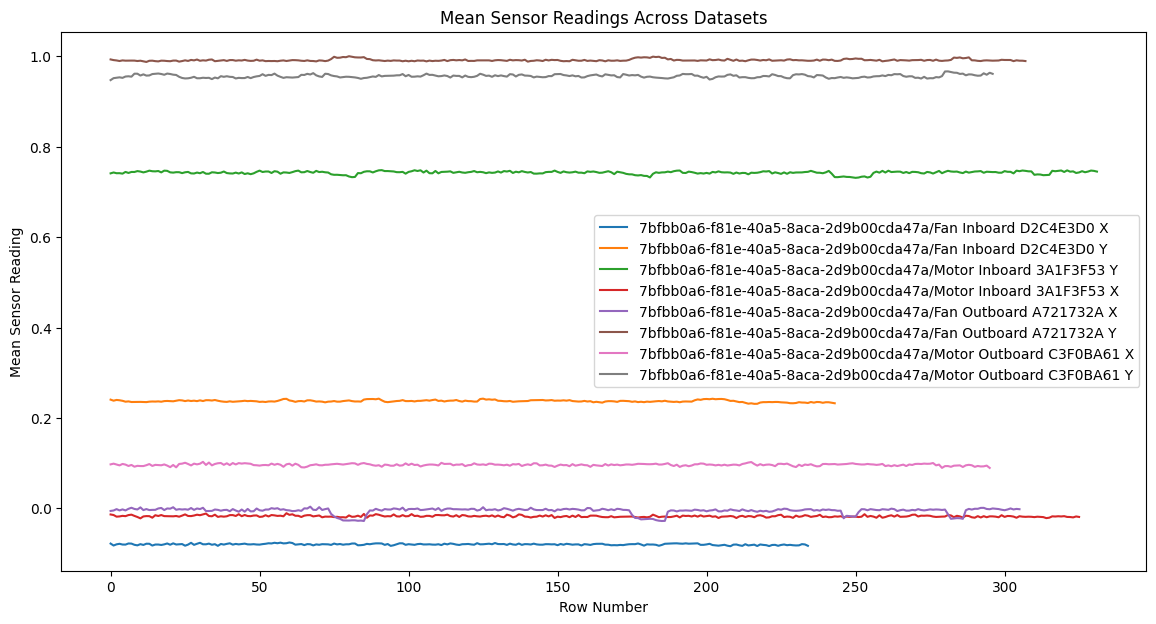

In [ ]:
# Basic statistics
print(all_row_means_df.describe())

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for column in all_row_means_df.columns:
    plt.plot(all_row_means_df.index, all_row_means_df[column], label=column)
plt.xlabel('Row Number')
plt.ylabel('Mean Sensor Reading')
plt.title('Mean Sensor Readings Across Datasets')
plt.legend()
plt.show()


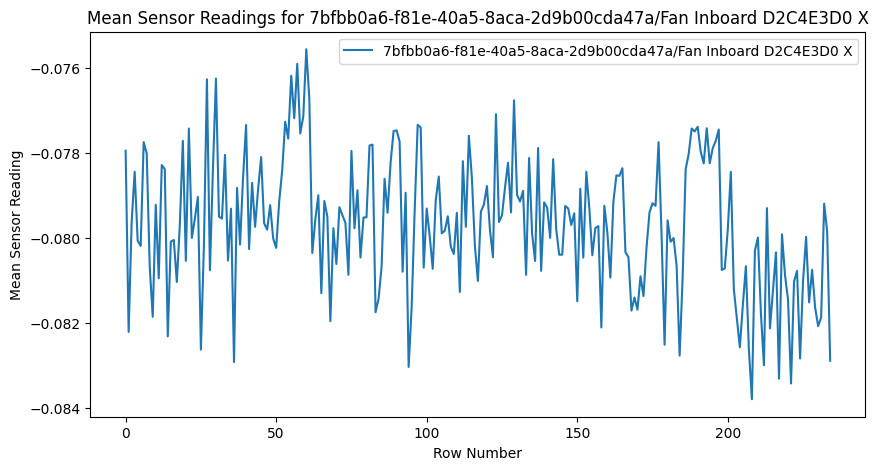

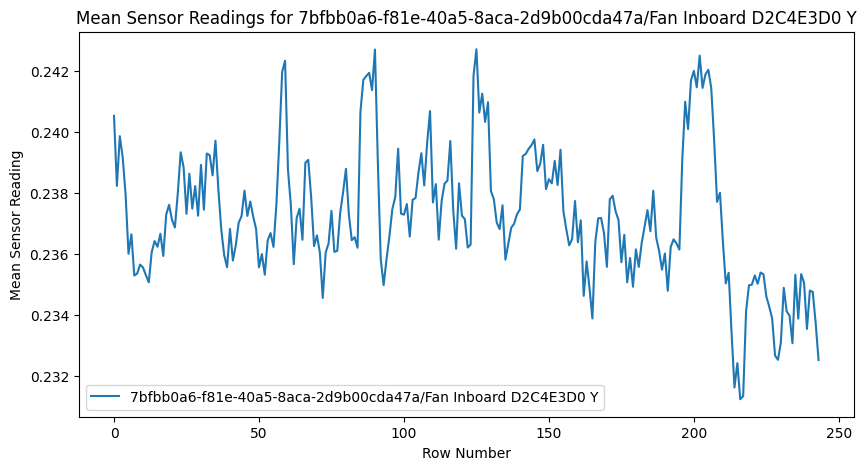

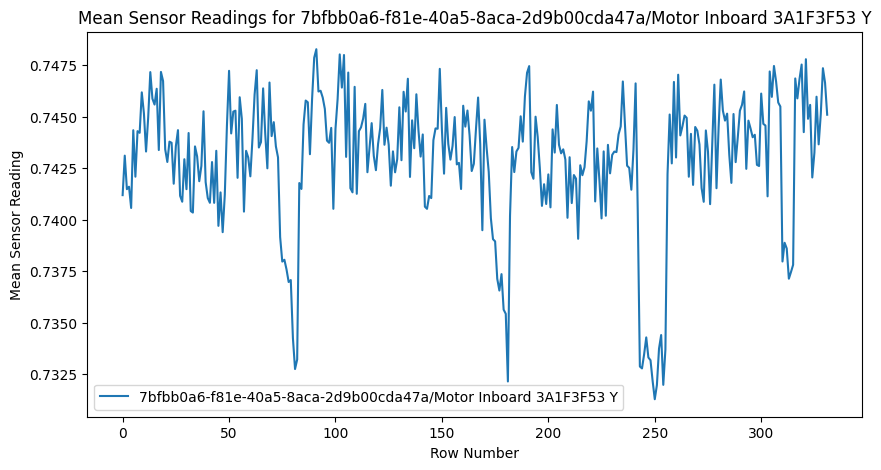

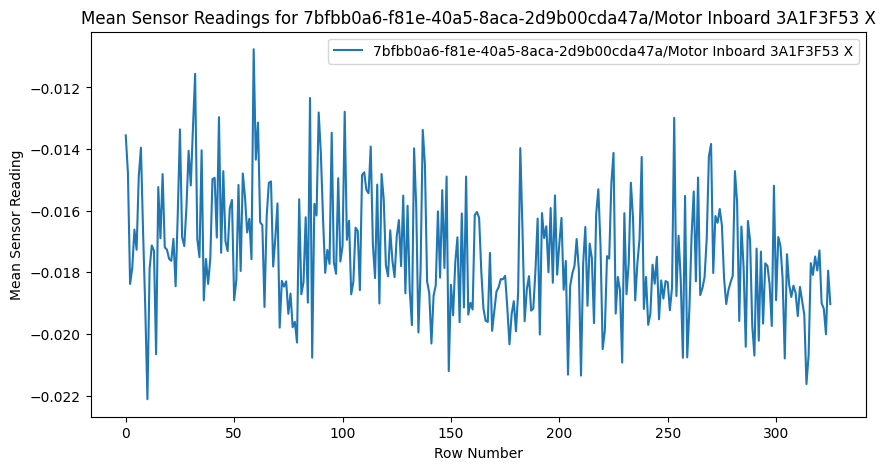

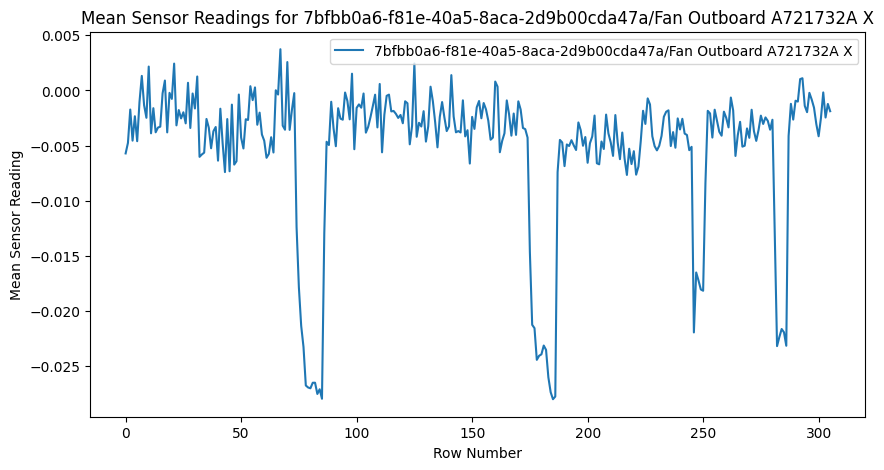

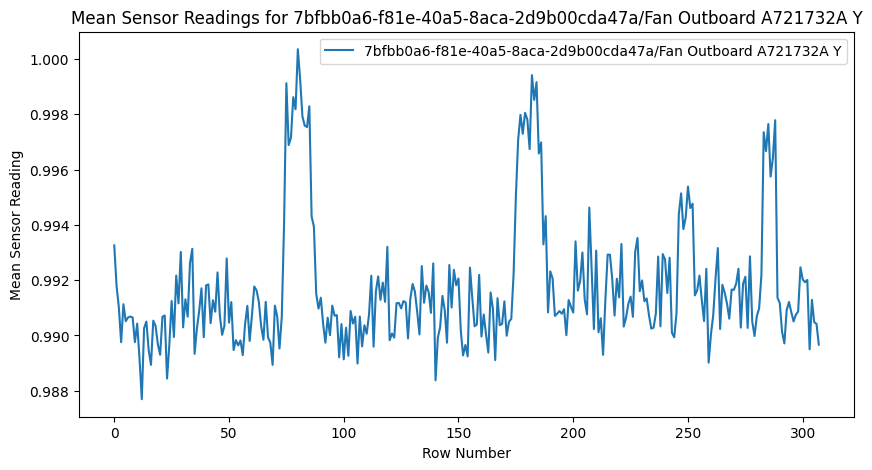

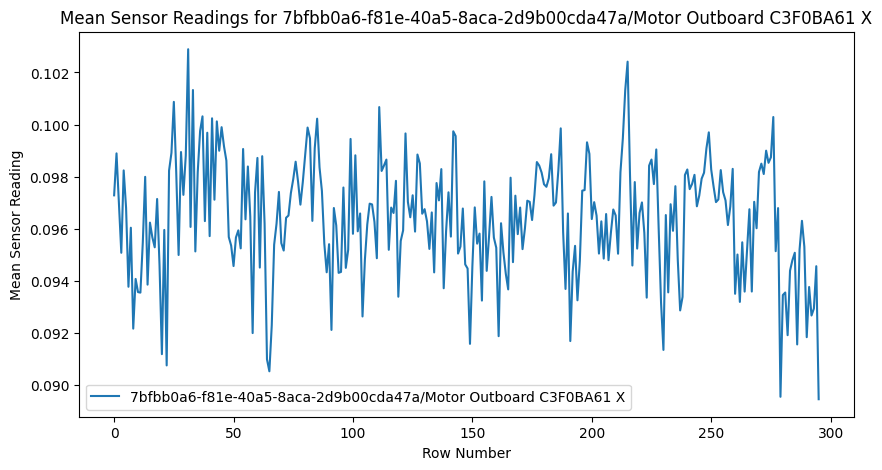

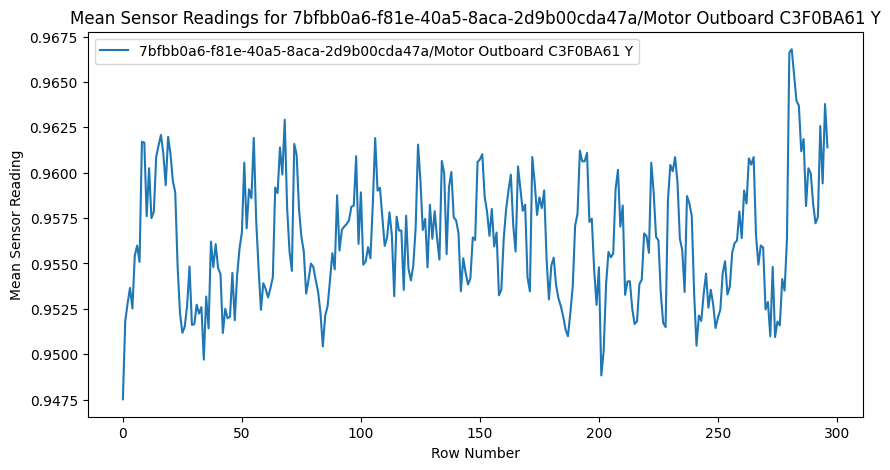

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'all_row_means_df' contains the row means for each dataset and
# its columns are named after each dataset for identification

for column in all_row_means_df.columns:
    plt.figure(figsize=(10, 5))  # Create a new figure for each dataset
    plt.plot(all_row_means_df.index, all_row_means_df[column], label=column)
    plt.xlabel('Row Number')
    plt.ylabel('Mean Sensor Reading')
    plt.title(f'Mean Sensor Readings for {column}')
    plt.legend()
    plt.show()


In [ ]:
def read_sensor_data(file_path):
    df = pd.read_csv(file_path, header=None)
    # Assuming the first column is 'timestamp', calculate the mean of sample data (excluding timestamp, samplerate, and samplelength)
    df['mean_sample_data'] = df.iloc[:, 3:].mean(axis=1)
    return df[['timestamp', 'mean_sample_data']]


In [ ]:
def read_sensor_data_with_correct_headers(file_path):
    # Specify the columns based on your description
    columns = ['timestamp', 'samplerate', 'samplelength'] + [f'sampledata_{i}' for i in range(1, 4097)]
    df = pd.read_csv(file_path, header=None, names=columns)
    # Compute the mean of the sample data for each row
    df['mean_sample_data'] = df.iloc[:, 3:].mean(axis=1)
    return df


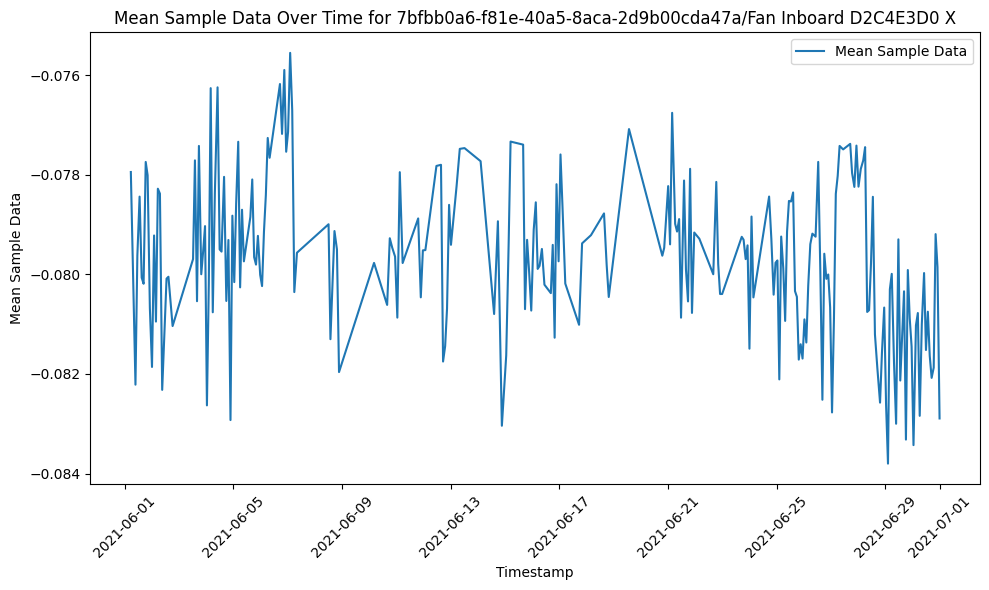

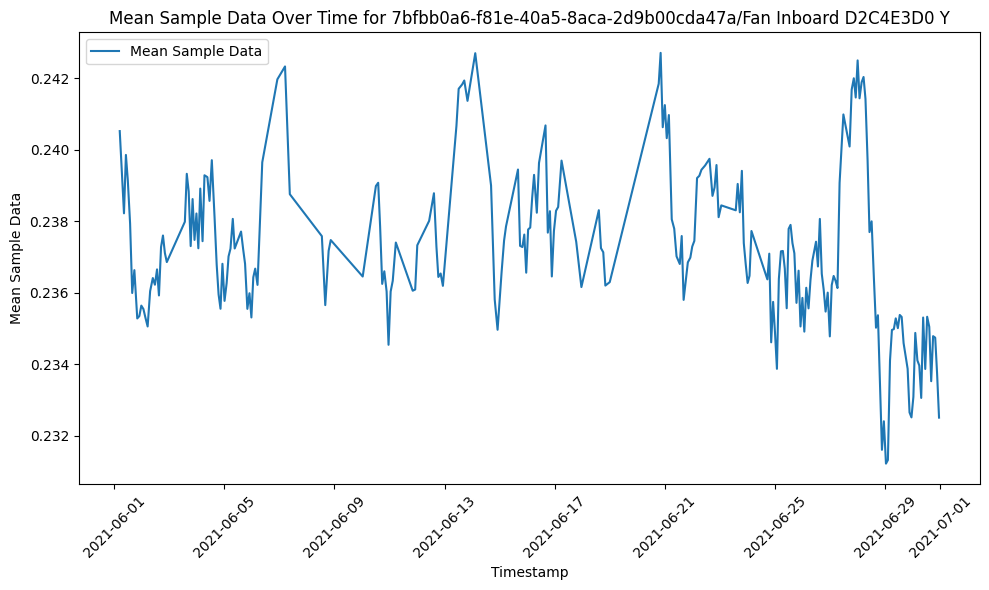

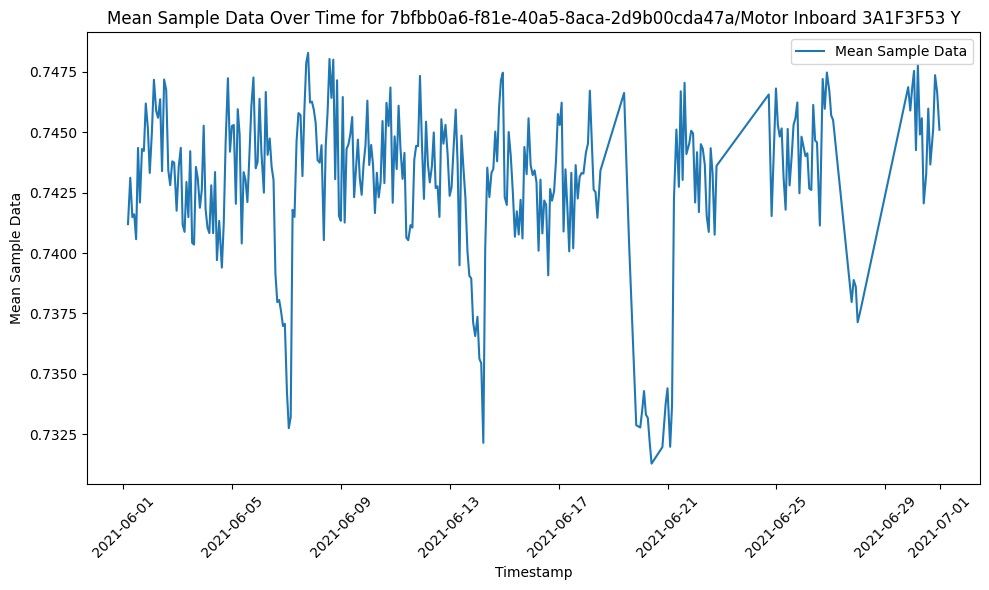

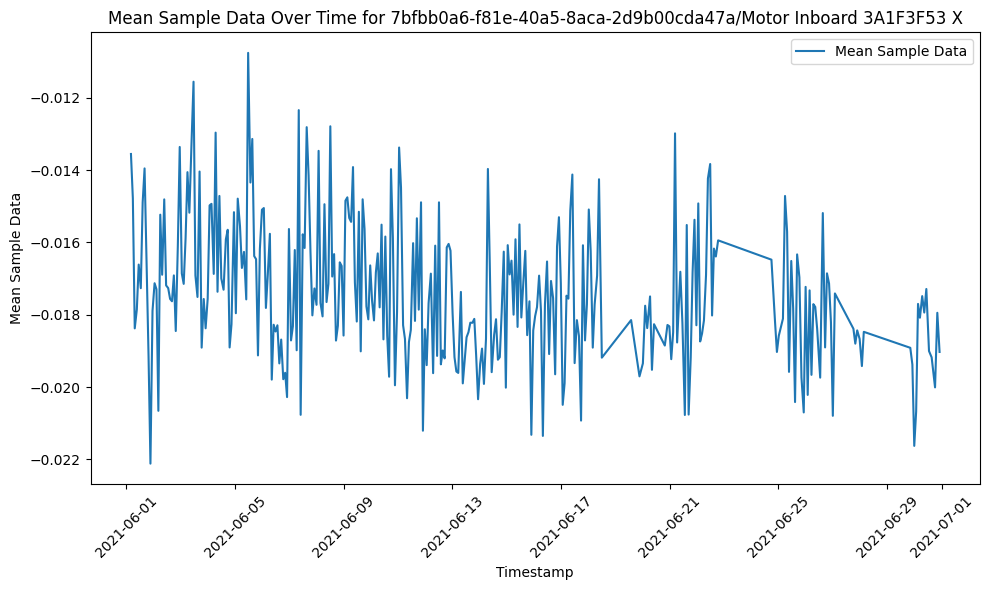

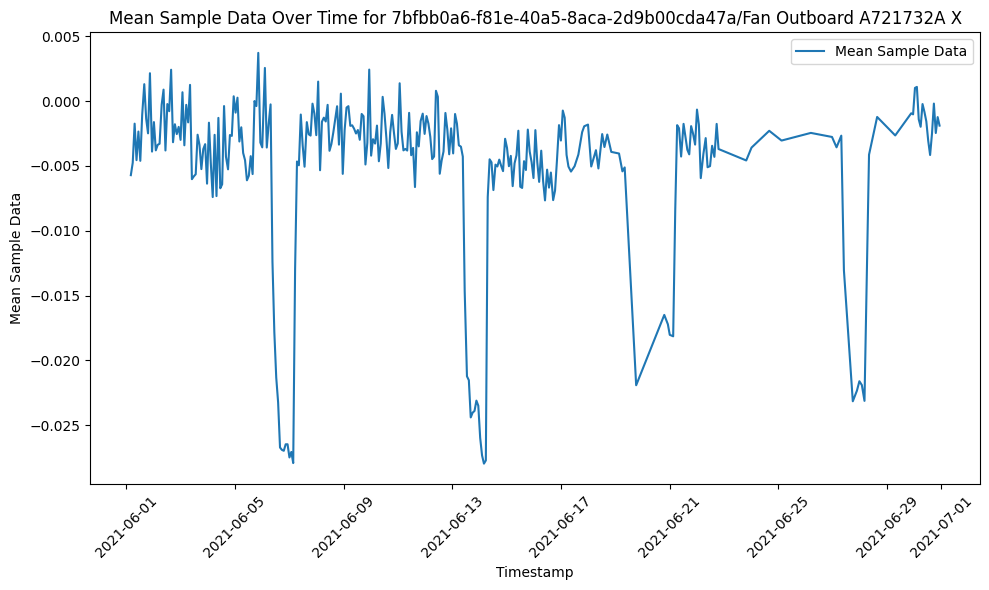

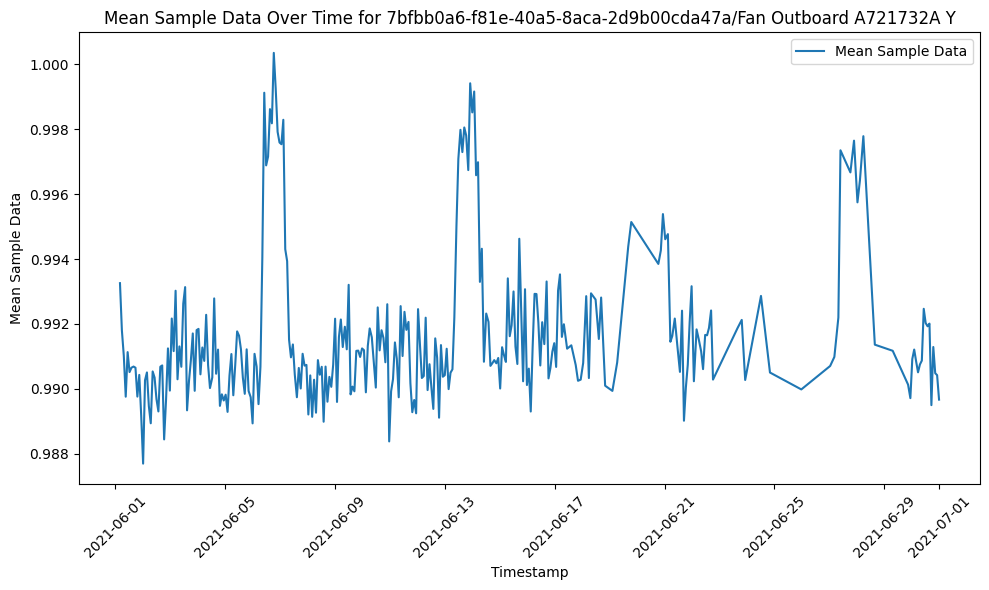

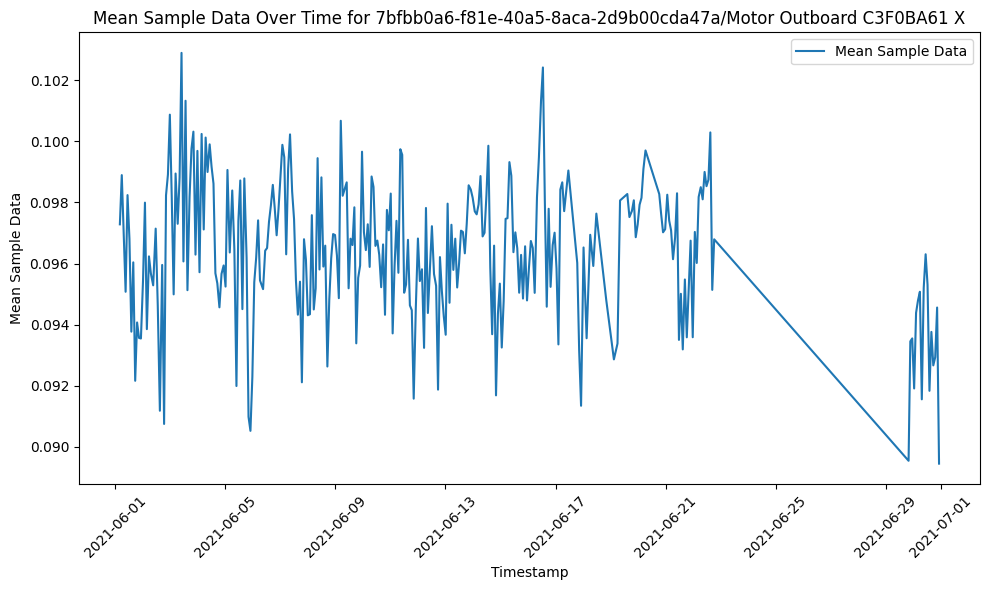

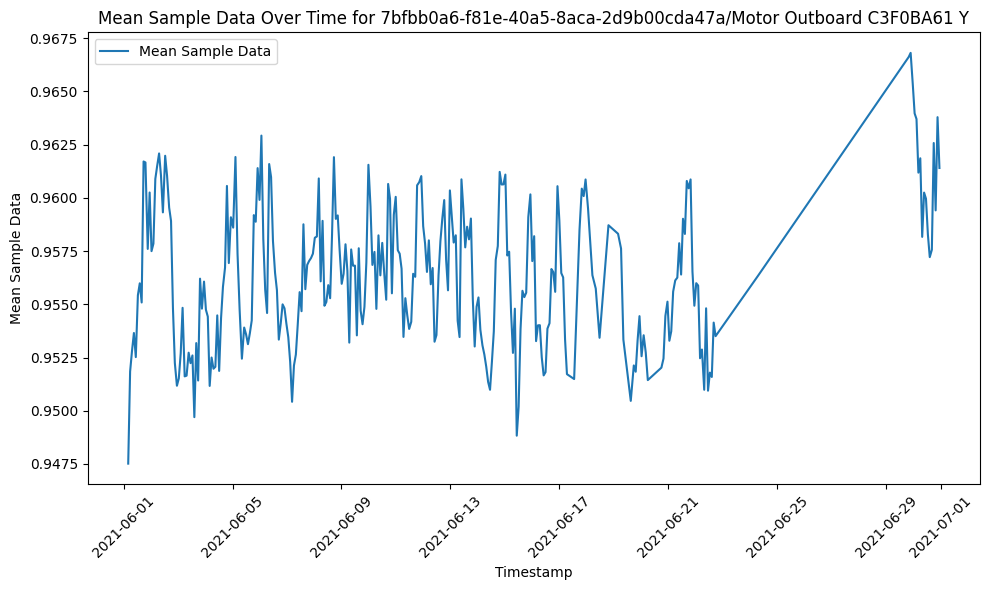

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the sensor_data_files list and extraction_dir as before
for location, serial, axis in sensor_data_files:
    file_path = os.path.join(extraction_dir, location, serial, axis, '0621.csv')
    df = read_sensor_data_with_correct_headers(file_path)

    # Ensure 'timestamp' is a datetime type for plotting
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Adjust unit if necessary

    # Plotting
    #plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
    plt.figure(figsize=(10, 6))
    plt.plot(df['timestamp'], df['mean_sample_data'], label='Mean Sample Data')
    plt.xlabel('Timestamp')
    plt.ylabel('Mean Sample Data')
    plt.title(f'Mean Sample Data Over Time for {location} {serial} {axis}')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.legend()
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()


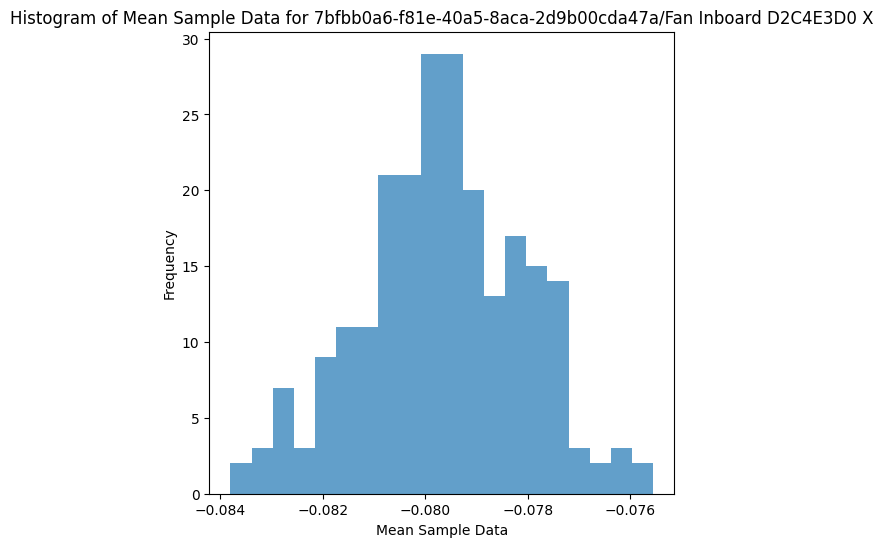

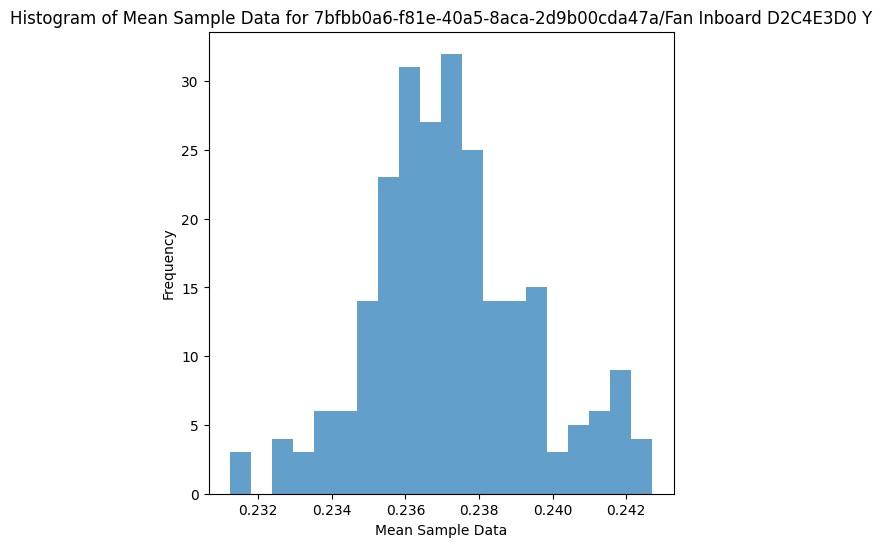

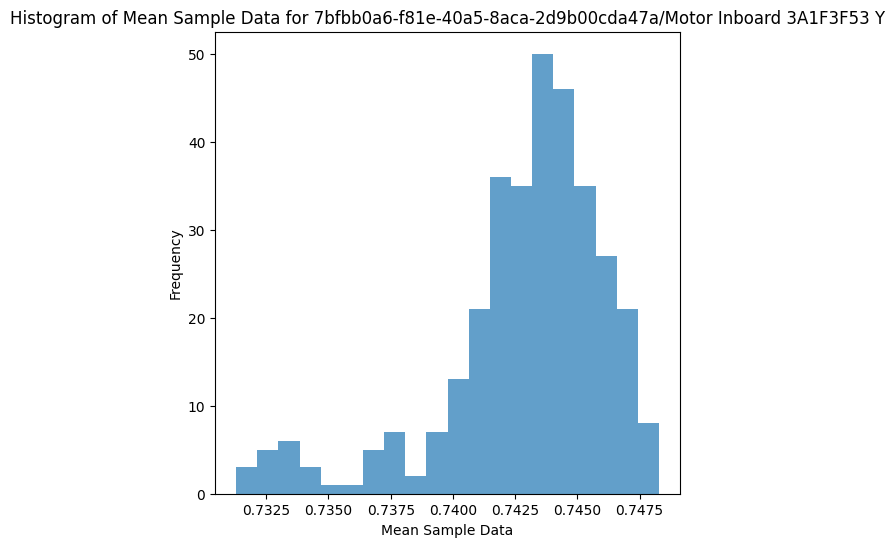

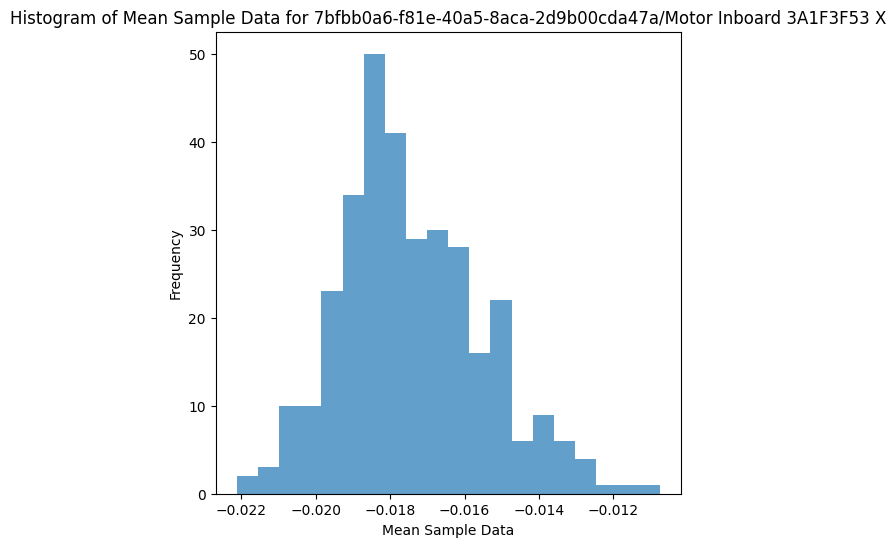

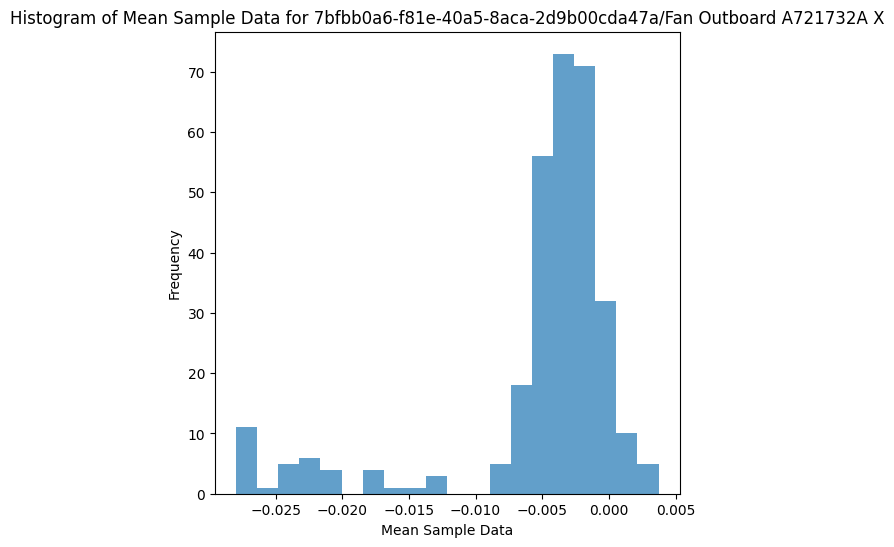

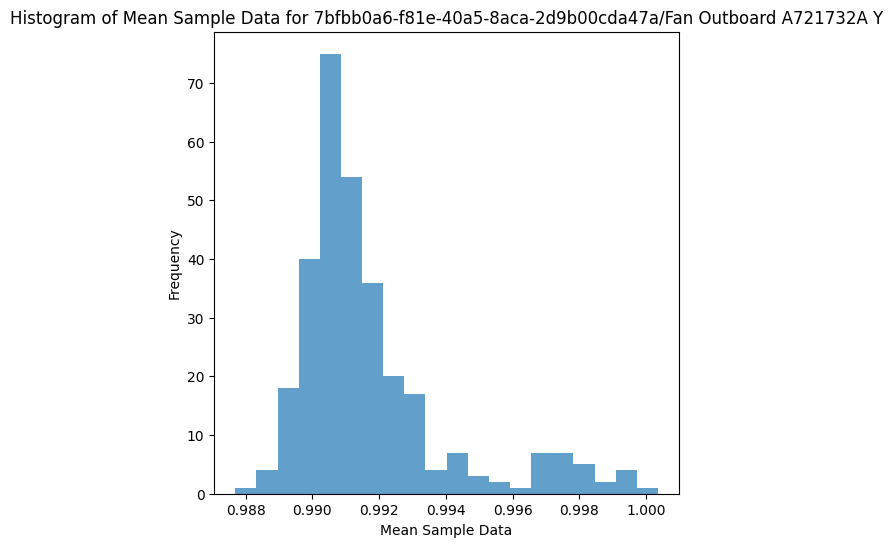

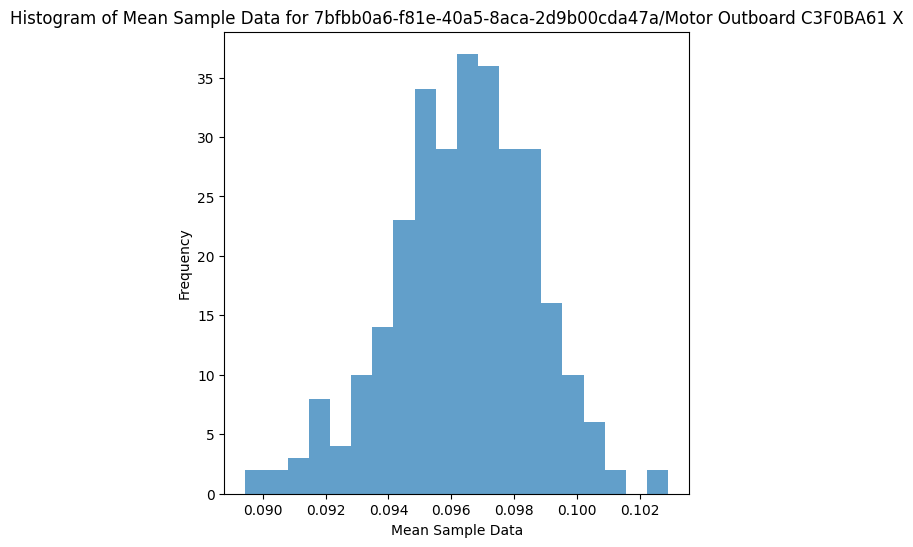

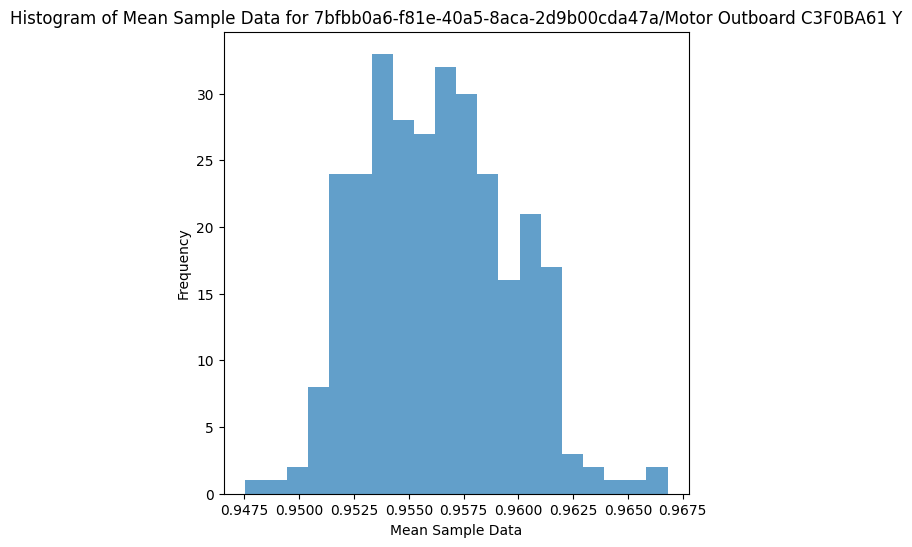

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'all_row_means_df' contains the row means for all your datasets
for column in all_row_means_df.columns:
    plt.figure(figsize=(6, 6))
    plt.hist(all_row_means_df[column], bins=20, alpha=0.7)
    plt.title(f'Histogram of Mean Sample Data for {column}')
    plt.xlabel('Mean Sample Data')
    plt.ylabel('Frequency')
    plt.show()


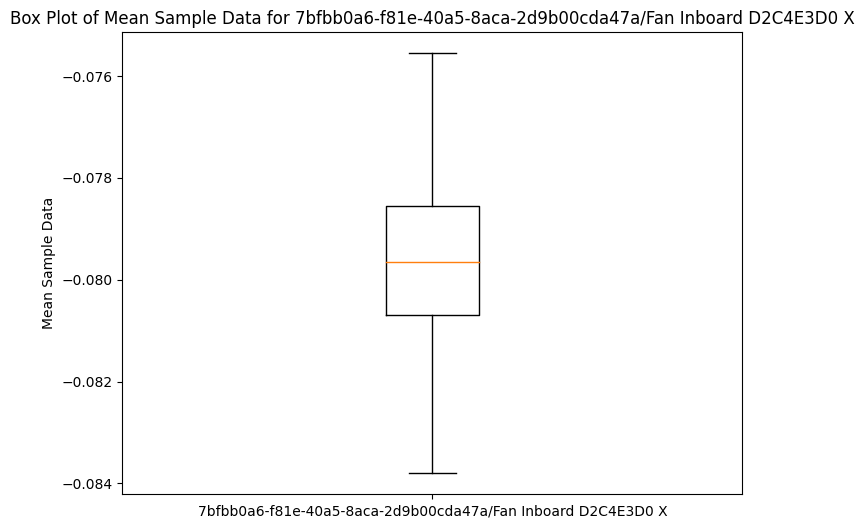

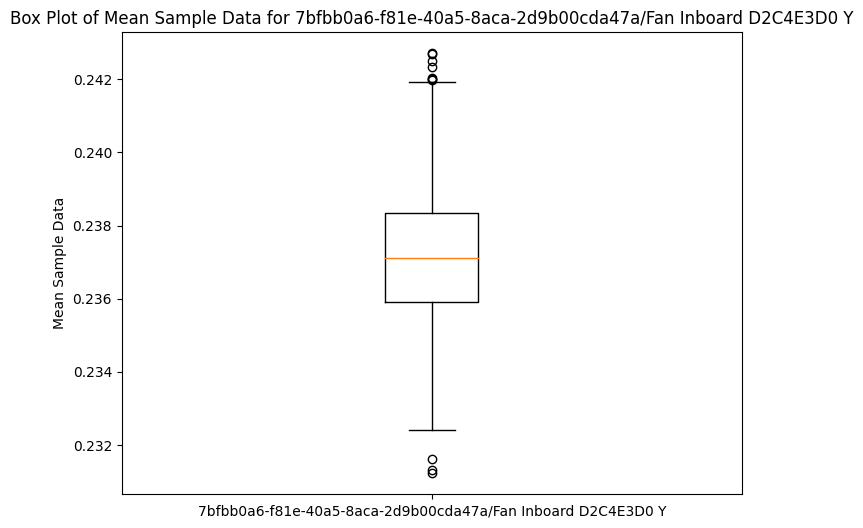

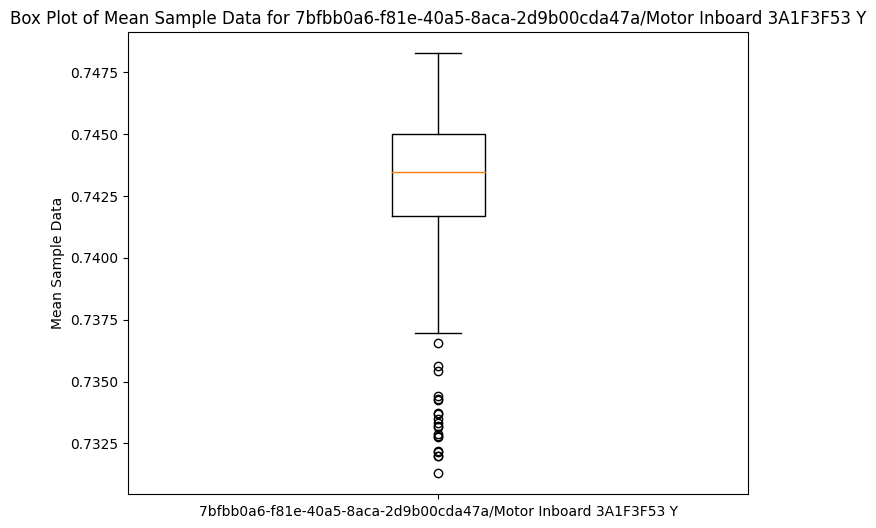

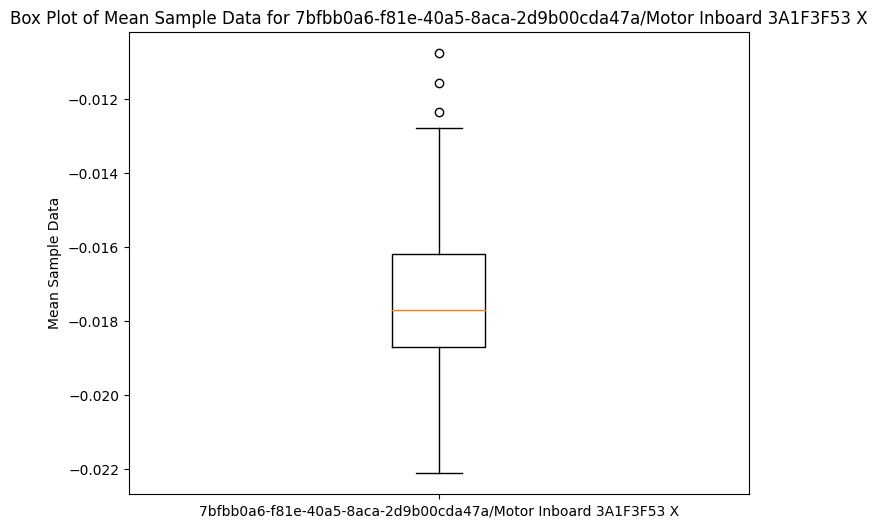

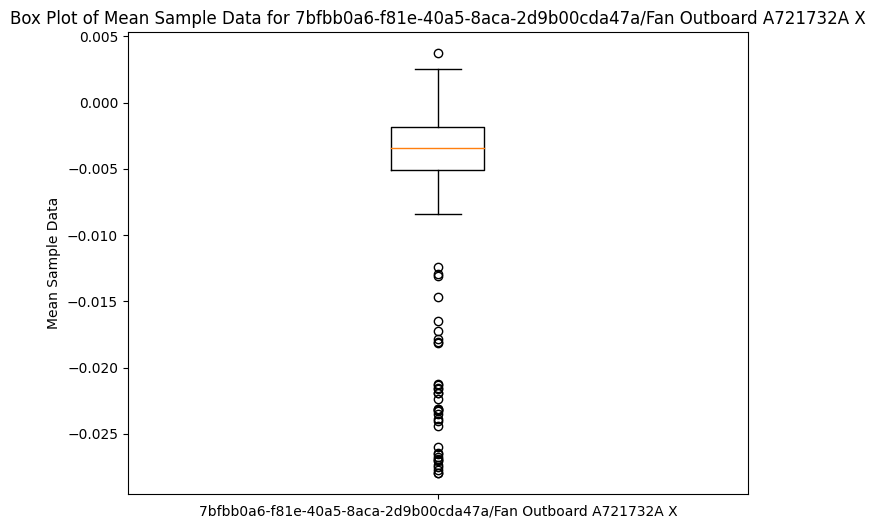

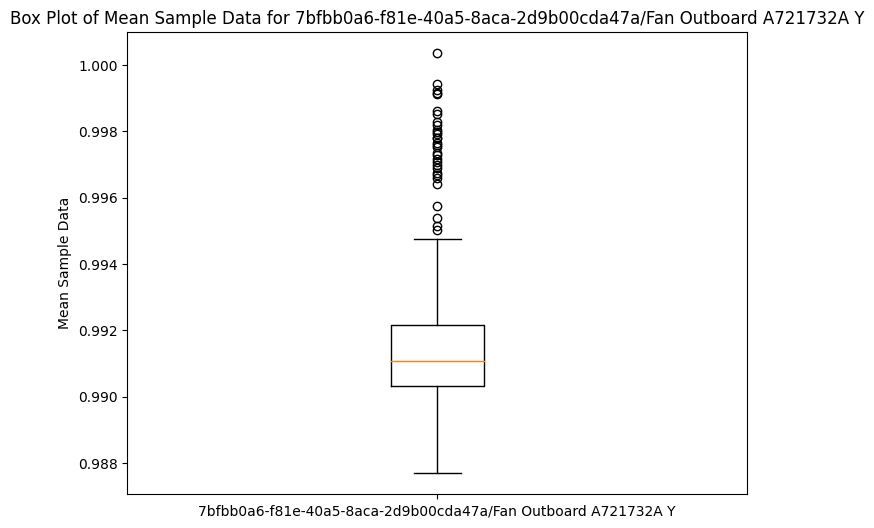

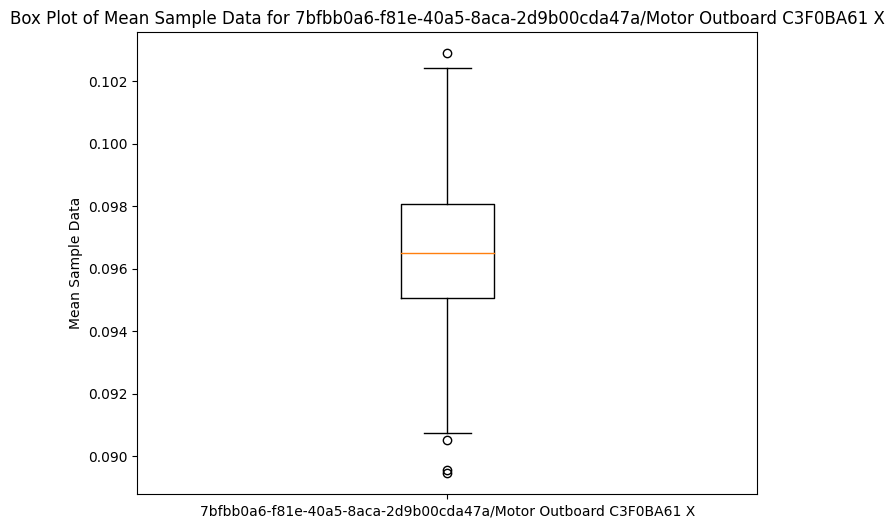

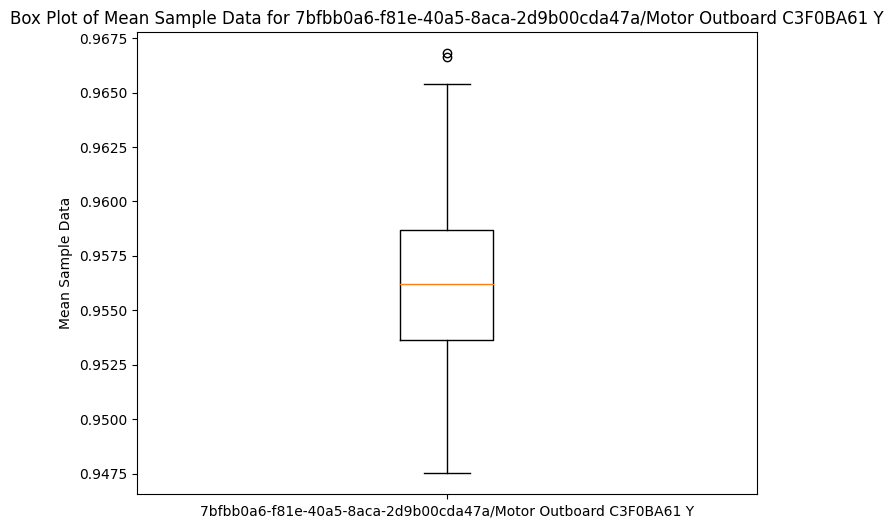

In [ ]:
# Using 'all_row_means_df' again for box plots
for column in all_row_means_df.columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(all_row_means_df[column].dropna())  # Drop NA values for plotting
    plt.title(f'Box Plot of Mean Sample Data for {column}')
    plt.ylabel('Mean Sample Data')
    plt.xticks([1], [column])  # Setting x-tick labels to the dataset name
    plt.show()


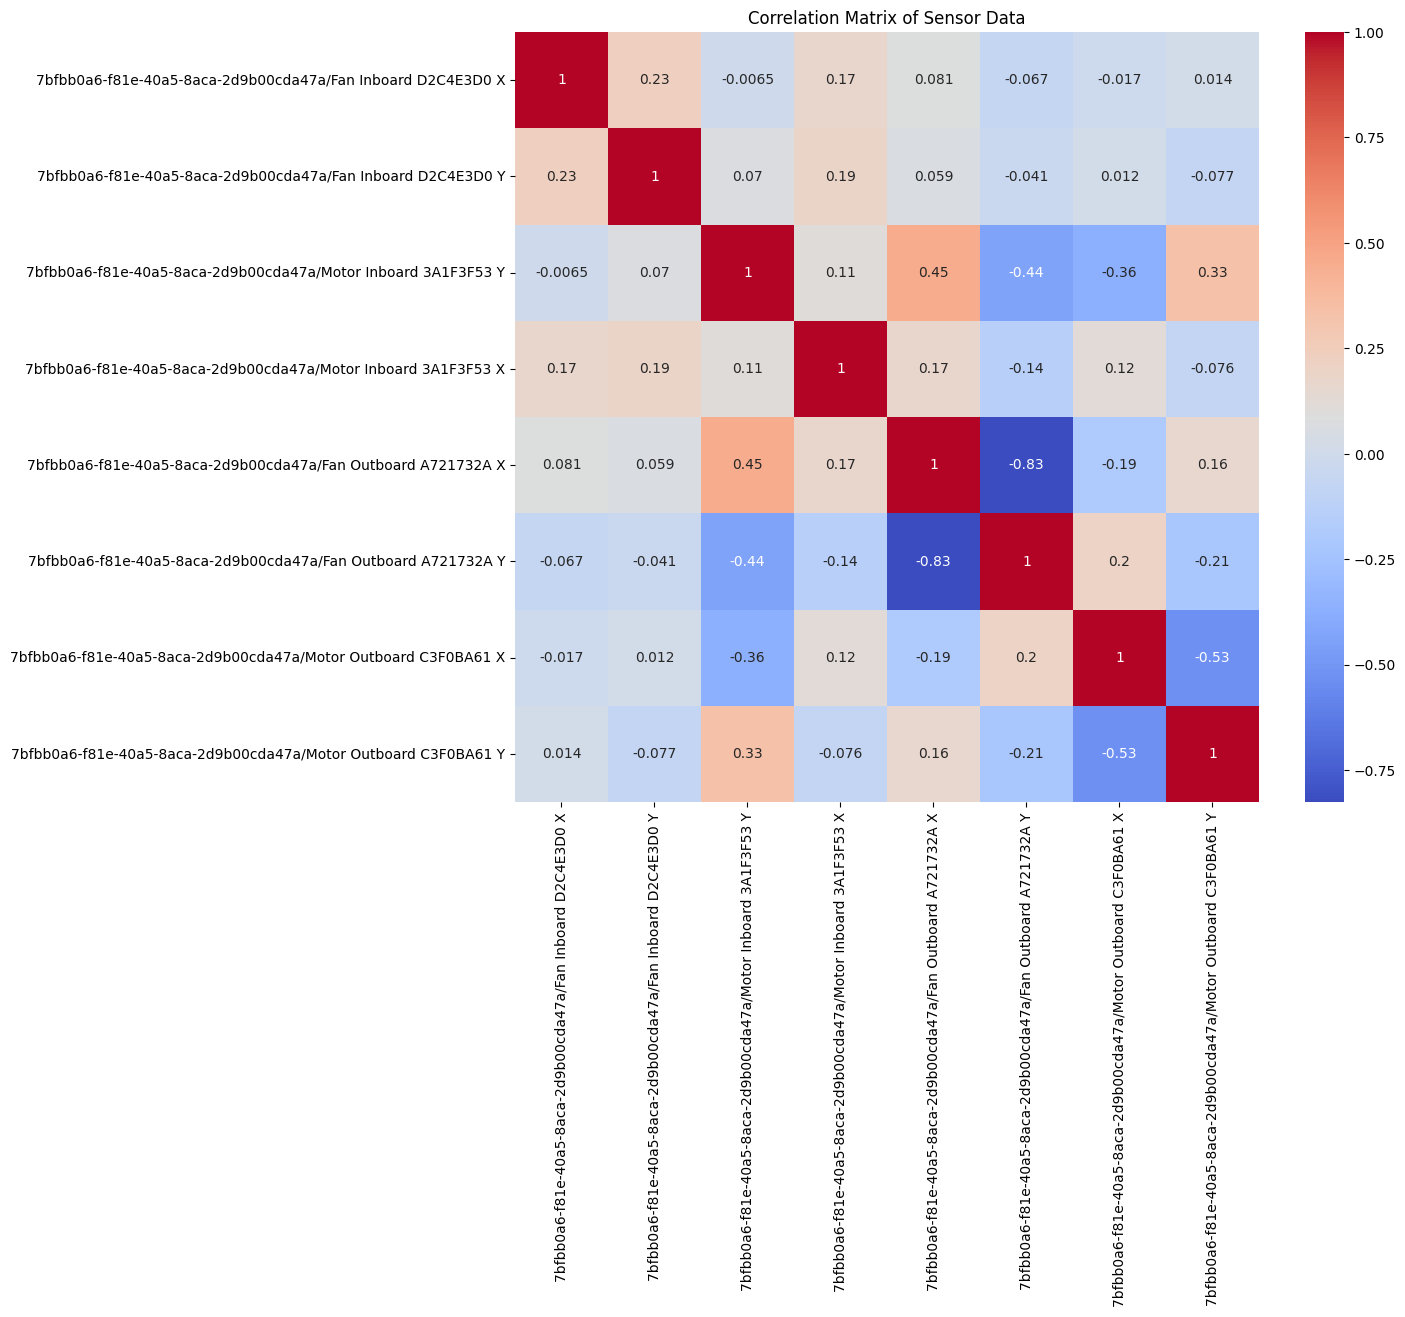

In [ ]:
import seaborn as sns

# Assuming 'all_row_means_df' contains the row means for your datasets
correlation_matrix = all_row_means_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Sensor Data')
plt.show()


**UNSUPERVISED APPROACH**





In [ ]:
from zipfile import ZipFile

# Path to the zip file
zip_path = '/content/drive/MyDrive/CodingChallege - InfoServ/KCF/analytics-challenge-data.zip'

# Function to list the contents of the zip file
def list_zip_contents(zip_path):
    with ZipFile(zip_path, 'r') as zip_ref:
        return zip_ref.namelist()

# List contents of the ZIP file
zip_contents = list_zip_contents(zip_path)

# Print the contents
for file in zip_contents:
    print(file)


7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Outboard/C3F0BA61/Y/0621.csv
7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Outboard/C3F0BA61/X/0621.csv
7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Outboard/A721732A/Y/0621.csv
7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Outboard/A721732A/X/0621.csv
7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Inboard/D2C4E3D0/Y/0621.csv
7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Inboard/D2C4E3D0/X/0621.csv
7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Inboard/3A1F3F53/Y/0621.csv
7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Inboard/3A1F3F53/X/0621.csv


In [ ]:
import pandas as pd

# Function to read CSV data into DataFrame and set the timestamp as index
def load_sensor_data(file_path, n_samples):
    df = pd.read_csv(file_path, header=None)
    df.columns = ['timestamp', 'samplerate', 'samplelength'] + [f'sample_{i}' for i in range(1, n_samples+1)]
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# Load each sensor dataset into its own DataFrame
# Replace these file paths with the actual paths to your CSV files
df1 = load_sensor_data('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Inboard/D2C4E3D0/X/0621.csv', 4096)
df2 = load_sensor_data('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Inboard/D2C4E3D0/Y/0621.csv', 4096)
df3 = load_sensor_data('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Inboard/3A1F3F53/X/0621.csv',4096)
df4 = load_sensor_data('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Inboard/3A1F3F53/Y/0621.csv',4096)
df5 = load_sensor_data('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Outboard/A721732A/X/0621.csv',4096)
df6 = load_sensor_data('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Outboard/A721732A/Y/0621.csv',4096)
df7 = load_sensor_data('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Outboard/C3F0BA61/X/0621.csv',4096)
df8 = load_sensor_data('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Motor Outboard/C3F0BA61/Y/0621.csv',4096)
# Repeat for all sensors...


In [ ]:
df1

samplerate  samplelength  sample_1  sample_2  \
timestamp                                                               
2021-06-01 05:25:36.160        8192          4096    0.0676    0.0091   
2021-06-01 09:30:57.415        8192          4096   -0.1017   -0.0485   
2021-06-01 11:10:43.020        8192          4096   -0.2196   -0.0804   
2021-06-01 13:09:37.661        8192          4096   -0.1709   -0.0237   
2021-06-01 15:00:42.385        8192          4096   -0.1044   -0.1921   
...                             ...           ...       ...       ...   
2021-06-30 16:50:22.266        8192          4096   -0.3038   -0.0078   
2021-06-30 18:40:48.965        8192          4096   -0.0991   -0.3694   
2021-06-30 20:21:21.487        8192          4096    0.2103    0.2484   
2021-06-30 22:00:56.006        8192          4096    0.0348    0.1314   
2021-06-30 23:51:15.299        8192          4096   -0.1150   -0.0556   

                         sample_3  sample_4  sample_5  sample_6  sample_7  \
timestamp                                                                   
2021-06-01 05:25:36.160   -0.1390   -0.3482   -0.0503    0.0055    0.0126   
2021-06-01 09:30:57.415   -0.1833   -0.2710   -0.1895   -0.0796   -0.0583   
2021-06-01 11:10:43.020    0.0392   -0.0131   -0.1966   -0.1975    0.0827   
2021-06-01 13:09:37.661    0.1492   -0.0078   -0.0982   -0.2356    0.0472   
2021-06-01 15:00:42.385   -0.1097   -0.3561   -0.1177   -0.2205   -0.0672   
...                           ...       ...       ...       ...       ...   
2021-06-30 16:50:22.266    0.1367    0.2671   -0.1895   -0.1328    0.1048   
2021-06-30 18:40:48.965   -0.2019   -0.0556   -0.1806   -0.1620   -0.3934   
2021-06-30 20:21:21.487   -0.0778   -0.3783    0.0694    0.2413    0.3096   
2021-06-30 22:00:56.006    0.1500   -0.1691   -0.0441    0.1084    0.2094   
2021-06-30 23:51:15.299    0.1846   -0.0769   -0.0751   -0.2312    0.1864   

                         sample_8  ...  sample_4087  sample_4088  sample_4089  \
timestamp                          ...                                          
2021-06-01 05:25:36.160   -0.2905  ...      -0.0725      -0.0184      -0.1354   
2021-06-01 09:30:57.415   -0.2835  ...      -0.1053       0.0304      -0.0219   
2021-06-01 11:10:43.020    0.0836  ...      -0.0565       0.0587       0.0756   
2021-06-01 13:09:37.661   -0.0193  ...       0.0295       0.0880      -0.1044   
2021-06-01 15:00:42.385   -0.2613  ...      -0.0893      -0.0627      -0.1443   
...                           ...  ...          ...          ...          ...   
2021-06-30 16:50:22.266    0.3238  ...      -0.3783      -0.0547       0.0578   
2021-06-30 18:40:48.965   -0.0893  ...      -0.0432       0.0445      -0.1496   
2021-06-30 20:21:21.487   -0.4005  ...       0.0339       0.1678       0.0454   
2021-06-30 22:00:56.006    0.0773  ...      -0.2187       0.0100      -0.1948   
2021-06-30 23:51:15.299   -0.0352  ...      -0.0485      -0.1496       0.1279   

                         sample_4090  sample_4091  sample_4092  sample_4093  \
timestamp                                                                     
2021-06-01 05:25:36.160      -0.1558      -0.0255      -0.1044      -0.0042   
2021-06-01 09:30:57.415      -0.2835      -0.1523      -0.0849       0.1048   
2021-06-01 11:10:43.020       0.1527      -0.0476      -0.0166       0.0534   
2021-06-01 13:09:37.661       0.0614      -0.0113       0.1554      -0.1248   
2021-06-01 15:00:42.385      -0.3615      -0.3322       0.1323       0.0694   
...                              ...          ...          ...          ...   
2021-06-30 16:50:22.266       0.0747      -0.3260      -0.2258      -0.1398   
2021-06-30 18:40:48.965      -0.0423      -0.4014       0.1403      -0.4031   
2021-06-30 20:21:21.487      -0.0920      -0.0583       0.0348       0.2289   
2021-06-30 22:00:56.006      -0.1789      -0.3845      -0.0725      -0.1390   
2021-06-30 23:51:15.299       0.0853      -0.0911      -0.0982      -0.

In [ ]:
# Assuming df1, df2, ..., df8 are already loaded as per your previous message

# Check the first and last timestamp in each DataFrame
print("DF1 Timestamp Range:", df1.index.min(), "-", df1.index.max())
print("DF2 Timestamp Range:", df2.index.min(), "-", df2.index.max())
print("DF3 Timestamp Range:", df3.index.min(), "_", df3.index.max())
print("DF4 Timestamp Range:", df4.index.min(), "_", df4.index.max())
print("DF5 Timestamp Range:", df5.index.min(), "_", df5.index.max())
print("DF6 Timestamp Range:", df6.index.min(), "_", df6.index.max())
print("DF7 Timestamp Range:", df7.index.min(), "_", df7.index.max())
print("DF8 Timestamp Range:", df8.index.min(), "_", df8.index.max())
# Continue for all your DataFrames (df3, df4, ..., df8)


DF1 Timestamp Range: 2021-06-01 05:25:36.160000 - 2021-06-30 23:51:15.299000
DF2 Timestamp Range: 2021-06-01 04:58:57.300000 - 2021-06-30 22:51:04.312000
DF3 Timestamp Range: 2021-06-01 04:01:37.320000 _ 2021-06-30 22:16:36.242000
DF4 Timestamp Range: 2021-06-01 04:01:37.320000 _ 2021-06-30 23:47:14.923000
DF5 Timestamp Range: 2021-06-01 04:09:32.268000 _ 2021-06-30 22:22:34.944000
DF6 Timestamp Range: 2021-06-01 04:09:32.268000 _ 2021-06-30 23:52:51.737000
DF7 Timestamp Range: 2021-06-01 04:05:44.379000 _ 2021-06-30 22:27:27.018000
DF8 Timestamp Range: 2021-06-01 04:05:44.379000 _ 2021-06-30 22:57:29.985000


In [ ]:
df1.head()
print(df1.describe())


       samplerate  samplelength    sample_1    sample_2    sample_3  \
count       235.0         235.0  235.000000  235.000000  235.000000   
mean       8192.0        4096.0   -0.086574   -0.090922   -0.073471   
std           0.0           0.0    0.140434    0.126717    0.141511   
min        8192.0        4096.0   -0.631000   -0.477600   -0.509500   
25%        8192.0        4096.0   -0.160650   -0.156700   -0.156700   
50%        8192.0        4096.0   -0.082200   -0.077800   -0.072500   
75%        8192.0        4096.0   -0.008650   -0.021100    0.011300   
max        8192.0        4096.0    0.350400    0.248400    0.437300   

         sample_4    sample_5    sample_6    sample_7    sample_8  ...  \
count  235.000000  235.000000  235.000000  235.000000  235.000000  ...   
mean    -0.083466   -0.075361   -0.089533   -0.082266   -0.080029  ...   
std      0.145710    0.141147    0.135477    0.143020    0.145089  ...   
min     -0.553800   -0.486500   -0.647800   -0.452800   -0.55830

In [ ]:
df1

samplerate  samplelength  sample_1  sample_2  \
timestamp                                                               
2021-06-01 05:25:36.160        8192          4096    0.0676    0.0091   
2021-06-01 09:30:57.415        8192          4096   -0.1017   -0.0485   
2021-06-01 11:10:43.020        8192          4096   -0.2196   -0.0804   
2021-06-01 13:09:37.661        8192          4096   -0.1709   -0.0237   
2021-06-01 15:00:42.385        8192          4096   -0.1044   -0.1921   
...                             ...           ...       ...       ...   
2021-06-30 16:50:22.266        8192          4096   -0.3038   -0.0078   
2021-06-30 18:40:48.965        8192          4096   -0.0991   -0.3694   
2021-06-30 20:21:21.487        8192          4096    0.2103    0.2484   
2021-06-30 22:00:56.006        8192          4096    0.0348    0.1314   
2021-06-30 23:51:15.299        8192          4096   -0.1150   -0.0556   

                         sample_3  sample_4  sample_5  sample_6  sample_7  \
timestamp                                                                   
2021-06-01 05:25:36.160   -0.1390   -0.3482   -0.0503    0.0055    0.0126   
2021-06-01 09:30:57.415   -0.1833   -0.2710   -0.1895   -0.0796   -0.0583   
2021-06-01 11:10:43.020    0.0392   -0.0131   -0.1966   -0.1975    0.0827   
2021-06-01 13:09:37.661    0.1492   -0.0078   -0.0982   -0.2356    0.0472   
2021-06-01 15:00:42.385   -0.1097   -0.3561   -0.1177   -0.2205   -0.0672   
...                           ...       ...       ...       ...       ...   
2021-06-30 16:50:22.266    0.1367    0.2671   -0.1895   -0.1328    0.1048   
2021-06-30 18:40:48.965   -0.2019   -0.0556   -0.1806   -0.1620   -0.3934   
2021-06-30 20:21:21.487   -0.0778   -0.3783    0.0694    0.2413    0.3096   
2021-06-30 22:00:56.006    0.1500   -0.1691   -0.0441    0.1084    0.2094   
2021-06-30 23:51:15.299    0.1846   -0.0769   -0.0751   -0.2312    0.1864   

                         sample_8  ...  sample_4087  sample_4088  sample_4089  \
timestamp                          ...                                          
2021-06-01 05:25:36.160   -0.2905  ...      -0.0725      -0.0184      -0.1354   
2021-06-01 09:30:57.415   -0.2835  ...      -0.1053       0.0304      -0.0219   
2021-06-01 11:10:43.020    0.0836  ...      -0.0565       0.0587       0.0756   
2021-06-01 13:09:37.661   -0.0193  ...       0.0295       0.0880      -0.1044   
2021-06-01 15:00:42.385   -0.2613  ...      -0.0893      -0.0627      -0.1443   
...                           ...  ...          ...          ...          ...   
2021-06-30 16:50:22.266    0.3238  ...      -0.3783      -0.0547       0.0578   
2021-06-30 18:40:48.965   -0.0893  ...      -0.0432       0.0445      -0.1496   
2021-06-30 20:21:21.487   -0.4005  ...       0.0339       0.1678       0.0454   
2021-06-30 22:00:56.006    0.0773  ...      -0.2187       0.0100      -0.1948   
2021-06-30 23:51:15.299   -0.0352  ...      -0.0485      -0.1496       0.1279   

                         sample_4090  sample_4091  sample_4092  sample_4093  \
timestamp                                                                     
2021-06-01 05:25:36.160      -0.1558      -0.0255      -0.1044      -0.0042   
2021-06-01 09:30:57.415      -0.2835      -0.1523      -0.0849       0.1048   
2021-06-01 11:10:43.020       0.1527      -0.0476      -0.0166       0.0534   
2021-06-01 13:09:37.661       0.0614      -0.0113       0.1554      -0.1248   
2021-06-01 15:00:42.385      -0.3615      -0.3322       0.1323       0.0694   
...                              ...          ...          ...          ...   
2021-06-30 16:50:22.266       0.0747      -0.3260      -0.2258      -0.1398   
2021-06-30 18:40:48.965      -0.0423      -0.4014       0.1403      -0.4031   
2021-06-30 20:21:21.487      -0.0920      -0.0583       0.0348       0.2289   
2021-06-30 22:00:56.006      -0.1789      -0.3845      -0.0725      -0.1390   
2021-06-30 23:51:15.299       0.0853      -0.0911      -0.0982      -0.

**FEATURE EXTRACTION**

*   Considering both df1 - faninboard_x & df2 - faninboard_y
*   case Studying fanInboard



In [ ]:
import numpy as np
import pandas as pd
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew, kurtosis

# Function to extract features from signal data
def extract_features(data):
    # Exclude the first three columns (metadata) and only consider signal data
    signal_data = data.iloc[:, 3:]

    # Time-domain features
    time_features = {
        'mean': signal_data.mean(axis=1),
        'std': signal_data.std(axis=1),
        'max': signal_data.max(axis=1),
        'min': signal_data.min(axis=1),
        'rms': np.sqrt(np.mean(signal_data**2, axis=1)),
    }

    # Frequency-domain features
    fft_vals = rfft(signal_data, axis=1)
    fft_freq = rfftfreq(signal_data.shape[1], d=1/8192)  # Sampling rate 8192
    fft_peak_freq = fft_freq[np.argmax(np.abs(fft_vals), axis=1)]
    fft_skewness = skew(fft_vals.real, axis=1)  # Extract real component for skewness
    fft_kurt = kurtosis(fft_vals.real, axis=1)   # Extract real component for kurtosis

    freq_features = {
        'fft_peak_freq': fft_peak_freq,
        'fft_skew': fft_skewness,
        'fft_kurtosis': fft_kurt,
    }

    return pd.DataFrame({**time_features, **freq_features})

# Example usage:
features_df1 = extract_features(df1)
features_df2 = extract_features(df2)


In [ ]:
features_df1

mean       std     max     min       rms  \
timestamp                                                               
2021-06-01 05:25:36.160 -0.077982  0.140746  0.3734 -0.6283  0.160890   
2021-06-01 09:30:57.415 -0.082210  0.148442  0.4550 -0.5769  0.169670   
2021-06-01 11:10:43.020 -0.079593  0.156321  0.4417 -0.6974  0.175401   
2021-06-01 13:09:37.661 -0.078418  0.146812  0.4692 -0.6877  0.166427   
2021-06-01 15:00:42.385 -0.080061  0.157571  0.4577 -0.6824  0.176726   
...                           ...       ...     ...     ...       ...   
2021-06-30 16:50:22.266 -0.082024  0.148393  0.5108 -0.6655  0.169538   
2021-06-30 18:40:48.965 -0.081869  0.145502  0.5436 -0.5990  0.166938   
2021-06-30 20:21:21.487 -0.079263  0.141471  0.4160 -0.5627  0.162148   
2021-06-30 22:00:56.006 -0.079882  0.151243  0.4630 -0.7418  0.171027   
2021-06-30 23:51:15.299 -0.082885  0.153838  0.4373 -0.6540  0.174729   

                         fft_peak_freq   fft_skew  fft_kurtosis  
timestamp                                                        
2021-06-01 05:25:36.160            0.0 -21.536396    799.678219  
2021-06-01 09:30:57.415            0.0 -13.111936    639.056830  
2021-06-01 11:10:43.020            0.0 -16.733707    614.392214  
2021-06-01 13:09:37.661            0.0 -13.788024    515.702067  
2021-06-01 15:00:42.385            0.0  -8.686291    456.784128  
...                                ...        ...           ...  
2021-06-30 16:50:22.266            0.0 -17.738876    610.953690  
2021-06-30 18:40:48.965            0.0 -19.526507    656.699895  
2021-06-30 20:21:21.487            0.0 -14.221303    566.300779  
2021-06-30 22:00:56.006            0.0 -15.083785    521.158457  
2021-06-30 23:51:15.299            0.0 -20.583640    726.501316  

[235 rows x 8 columns]

In [ ]:
features_df2

mean       std     max     min       rms  \
timestamp                                                               
2021-06-01 04:58:57.300  0.240525  0.171117  0.9569 -0.6698  0.295172   
2021-06-01 08:40:40.810  0.238205  0.167842  0.7949 -0.4015  0.291386   
2021-06-01 10:21:18.432  0.239860  0.168576  1.0211 -0.3964  0.293162   
2021-06-01 11:59:16.439  0.239033  0.168270  0.9089 -0.4099  0.292309   
2021-06-01 14:00:28.821  0.237911  0.184894  0.8970 -0.6487  0.301296   
...                           ...       ...     ...     ...       ...   
2021-06-30 16:01:06.521  0.233515  0.169291  0.8709 -0.4175  0.288413   
2021-06-30 17:40:44.422  0.234834  0.183555  0.9173 -0.5795  0.298046   
2021-06-30 19:31:05.231  0.234771  0.182375  0.8751 -0.5821  0.297271   
2021-06-30 21:10:36.992  0.233732  0.176988  0.8363 -0.3627  0.293168   
2021-06-30 22:51:04.312  0.232472  0.182912  0.8734 -0.4285  0.295790   

                         fft_peak_freq   fft_skew  fft_kurtosis  
timestamp                                                        
2021-06-01 04:58:57.300            0.0  39.238035   1690.472830  
2021-06-01 08:40:40.810            0.0  39.278582   1694.449072  
2021-06-01 10:21:18.432            0.0  37.971220   1622.517996  
2021-06-01 11:59:16.439            0.0  38.156909   1626.880622  
2021-06-01 14:00:28.821            0.0  35.539562   1515.094818  
...                                ...        ...           ...  
2021-06-30 16:01:06.521            0.0  38.065985   1617.666949  
2021-06-30 17:40:44.422            0.0  37.392686   1585.028251  
2021-06-30 19:31:05.231            0.0  34.974169   1472.871677  
2021-06-30 21:10:36.992            0.0  35.226999   1467.247282  
2021-06-30 22:51:04.312            0.0  36.988770   1553.724110  

[244 rows x 8 columns]

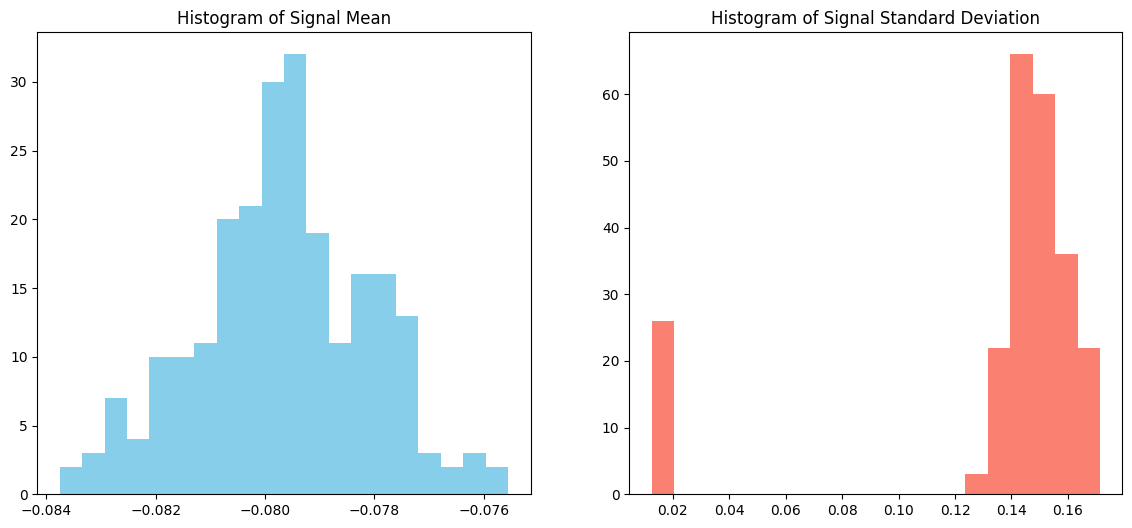

In [ ]:
import matplotlib.pyplot as plt

# Plotting histograms for mean and std features
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(features_df1['mean'], bins=20, color='skyblue')
plt.title('Histogram of Signal Mean')

plt.subplot(1, 2, 2)
plt.hist(features_df1['std'], bins=20, color='salmon')
plt.title('Histogram of Signal Standard Deviation')

plt.show()


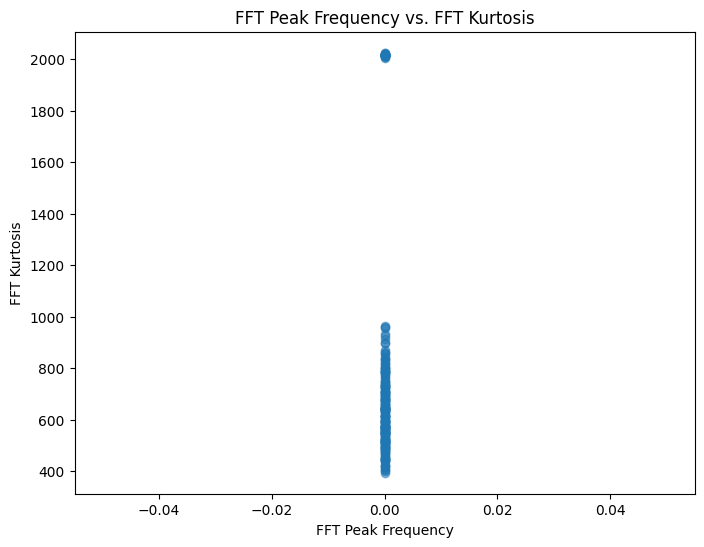

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(features_df1['fft_peak_freq'], features_df1['fft_kurtosis'], alpha=0.5)
plt.xlabel('FFT Peak Frequency')
plt.ylabel('FFT Kurtosis')
plt.title('FFT Peak Frequency vs. FFT Kurtosis')
plt.show()


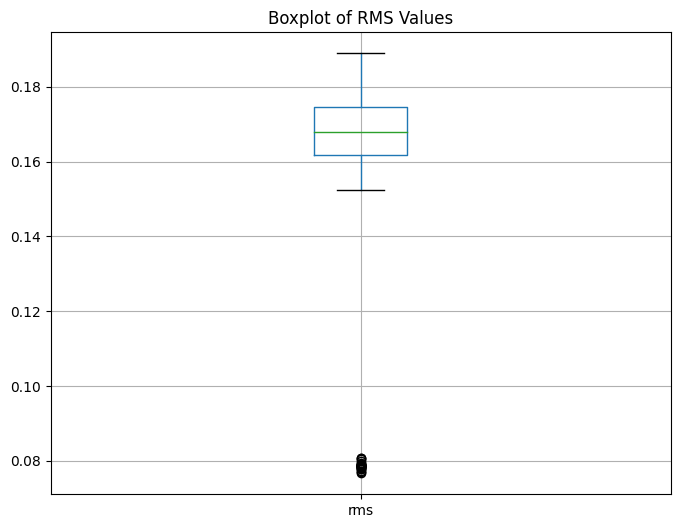

In [ ]:
# Boxplot for 'rms' feature
plt.figure(figsize=(8, 6))
features_df1.boxplot(column=['rms'])
plt.title('Boxplot of RMS Values')
plt.show()


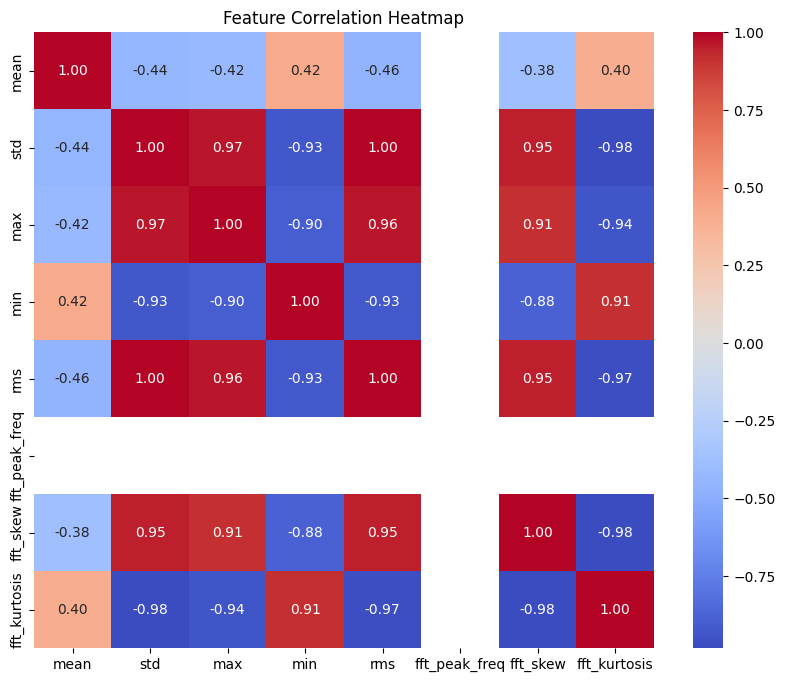

In [ ]:
import seaborn as sns

# Calculating correlation matrix
corr_matrix = features_df1.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
features_df1.shape

(235, 8)

In [ ]:
features_df2.shape

(244, 8)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Assuming features_df1 and features_df2 are the feature dataframes obtained from df1 and df2

# Check and ensure that lengths of features_df1 and features_df2 are the same
if len(features_df1) != len(features_df2):
    # Handle the mismatch in lengths here, such as dropping or imputing missing values, aligning timestamps, etc.
    # For simplicity, let's assume we drop any rows with missing values
    features_df1.dropna(inplace=True)
    features_df2.dropna(inplace=True)

# Combine the features of df1 and df2
combined_features = pd.concat([features_df1, features_df2], axis=1)

# Impute missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
combined_features_imputed = imputer.fit_transform(combined_features)

# Initialize KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the KMeans model and predict cluster labels
clusters = kmeans.fit_predict(combined_features_imputed)

# Check the lengths of df1, df2, and clusters to identify any mismatches
print("Length of df1:", len(df1))
print("Length of df2:", len(df2))
print("Length of clusters:", len(clusters))

# Create df_with_clusters DataFrame to assign cluster labels
df_with_clusters = pd.concat([df1, df2], axis=1)

# Assign cluster labels to each row in df_with_clusters
df_with_clusters['Cluster'] = clusters

# Compute the majority class of each cluster
cluster_majority_class = df_with_clusters.groupby('Cluster').mean().mean(axis=1) > 0.5

# Map cluster labels to binary labels (On/Off)
label_mapping = {cluster: int(majority_class) for cluster, majority_class in cluster_majority_class.items()}
df_with_clusters['Predicted_Label'] = df_with_clusters['Cluster'].map(label_mapping)

# Optionally, visualize the distribution of predicted labels


Length of df1: 235
Length of df2: 244
Length of clusters: 459


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
combined_features.describe()

mean         std         max         min         rms  \
count  235.000000  235.000000  235.000000  235.000000  235.000000   
mean    -0.079673    0.134750    0.393720   -0.595084    0.159826   
std      0.001565    0.043880    0.157497    0.180217    0.029655   
min     -0.083752    0.012474   -0.036100   -0.949200    0.076669   
25%     -0.080679    0.140764    0.390750   -0.691250    0.161838   
50%     -0.079658    0.147511    0.434600   -0.638100    0.168002   
75%     -0.078533    0.155291    0.476300   -0.578650    0.174612   
max     -0.075557    0.171337    0.603900   -0.118600    0.188937   

       fft_peak_freq    fft_skew  fft_kurtosis        mean         std  \
count          235.0  235.000000    235.000000  244.000000  244.000000   
mean             0.0  -20.873771    778.871418    0.237214    0.170551   
std              0.0    9.125588    453.546656    0.002213    0.053566   
min              0.0  -44.913573    394.606277    0.231222    0.011845   
25%              0.0  -21.681208    542.247605    0.235904    0.176189   
50%              0.0  -18.370351    638.903169    0.237115    0.185195   
75%              0.0  -15.877550    770.004075    0.238319    0.193197   
max              0.0   -8.686291   2024.459379    0.242714    0.304795   

              max         min         rms  fft_peak_freq    fft_skew  \
count  244.000000  244.000000  244.000000          244.0  244.000000   
mean     0.910918   -0.443757    0.296310            0.0   37.368275   
std      0.229056    0.230157    0.020367            0.0    3.209954   
min      0.279400   -0.950800    0.239388            0.0   30.381419   
25%      0.875100   -0.564125    0.294881            0.0   35.283849   
50%      0.947700   -0.486300    0.300394            0.0   37.066014   
75%      1.019825   -0.409900    0.305847            0.0   38.514740   
max      1.379700    0.203500    0.388719            0.0   45.180134   

       fft_kurtosis  
count    244.000000  
mean    1589.503751  
std      180.242779  
min     1238.236087  
25%     1466.864525  
50%     1562.142238  
75%     1651.044344  
max     2040.496976

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.impute import SimpleImputer
# from sklearn.cluster import KMeans

# from sklearn.metrics import silhouette_score

# # Define a range of cluster numbers to explore
# cluster_range = range(2, 11)  # Explore clusters from 2 to 10

# best_silhouette_score = -1  # Initialize with a low value
# best_clusters = None

# # Iterate over each cluster number
# for n_clusters in cluster_range:
#     # Initialize KMeans clustering with the current number of clusters
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)

#     # Fit the KMeans model and predict cluster labels
#     clusters = kmeans.fit_predict(combined_features_imputed)

#     # Compute the silhouette score for the current clustering
#     silhouette = silhouette_score(combined_features_imputed, clusters)

#     # Print the silhouette score for reference
#     print(f"Number of clusters: {n_clusters}, Silhouette score: {silhouette}")

#     # Update the best silhouette score and clusters if the current score is higher
#     if silhouette > best_silhouette_score:
#         best_silhouette_score = silhouette
#         best_clusters = clusters

# # Use the best clustering result
# clusters = best_clusters

# # Proceed with assigning cluster labels and computing predicted labels as before...


In [ ]:
# # Initialize KMeans clustering with 2 clusters
# kmeans = KMeans(n_clusters=2, random_state=42)

# # Fit the KMeans model and predict cluster labels
# clusters = kmeans.fit_predict(combined_features_imputed)

# # Assign cluster labels to each row in df_with_clusters
# df_with_clusters['Cluster'] = clusters

# # Compute the majority class of each cluster
# cluster_majority_class = df_with_clusters.groupby('Cluster').mean().mean(axis=1) > 0.5

# # Map cluster labels to binary labels (On/Off)
# label_mapping = {cluster: int(majority_class) for cluster, majority_class in cluster_majority_class.items()}
# df_with_clusters['Predicted_Label'] = df_with_clusters['Cluster'].map(label_mapping)

# # Optionally, visualize the distribution of predicted labels


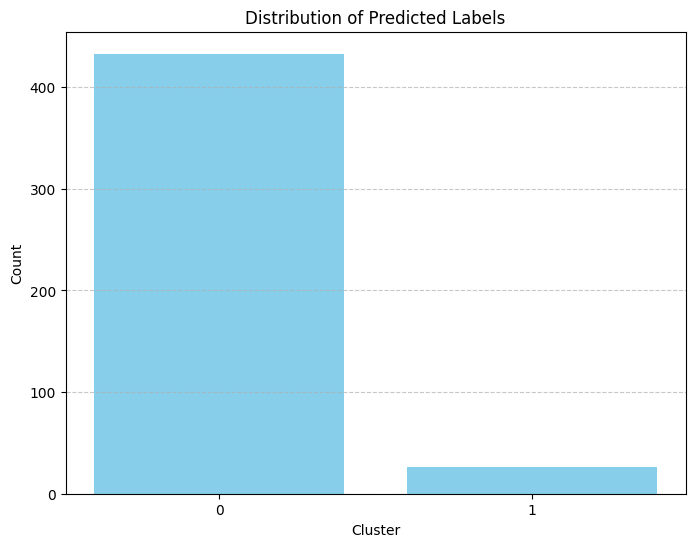

In [ ]:
import matplotlib.pyplot as plt

# Count the number of data points in each cluster
cluster_counts = df_with_clusters['Cluster'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.xticks(cluster_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming features_df1 and features_df2 are the feature dataframes obtained from df1 and df2

# Check and ensure that lengths of features_df1 and features_df2 are the same
if len(features_df1) != len(features_df2):
    # Handle the mismatch in lengths here, such as dropping or imputing missing values, aligning timestamps, etc.
    # For simplicity, let's assume we drop any rows with missing values
    features_df1.dropna(inplace=True)
    features_df2.dropna(inplace=True)

# Combine the features of df1 and df2
combined_features = pd.concat([features_df1, features_df2], axis=1)

# Impute missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
combined_features_imputed = imputer.fit_transform(combined_features)

# Initialize KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the KMeans model and predict cluster labels
clusters = kmeans.fit_predict(combined_features_imputed)

# Create df_with_clusters DataFrame to assign cluster labels
df_with_clusters = pd.concat([df1, df2], axis=1)

# Assign cluster labels to each row in df_with_clusters
df_with_clusters['Cluster'] = clusters

# Compute the majority class of each cluster
cluster_majority_class = df_with_clusters.groupby('Cluster').mean().mean(axis=1) > 0.5

# Map cluster labels to binary labels (On/Off)
label_mapping = {cluster: int(majority_class) for cluster, majority_class in cluster_majority_class.items()}
df_with_clusters['Predicted_Label'] = df_with_clusters['Cluster'].map(label_mapping)

# Split the data into features (X) and labels (y)
X = combined_features_imputed
y = df_with_clusters['Predicted_Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 1.0


## **Considering Fanoutboard_X as Case Study**

In [ ]:
import pandas as pd

# Function to read CSV data into DataFrame without setting the timestamp as index
def load_sensor_data(file_path, n_samples):
    df = pd.read_csv(file_path, header=None)
    df.columns = ['timestamp', 'samplerate', 'samplelength'] + [f'sample_{i}' for i in range(1, n_samples+1)]
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    # No longer setting the 'timestamp' as an index
    return df

# Load each sensor dataset into its own DataFrame
# Adjust the file paths to your actual CSV files
df_fanoutboard_x = load_sensor_data('7bfbb0a6-f81e-40a5-8aca-2d9b00cda47a/Fan Outboard/A721732A/X/0621.csv', 4096)
# Similarly, replace paths for df2 to df8 with your actual CSV file paths


In [ ]:
df_fanoutboard_x

timestamp  samplerate  samplelength  sample_1  sample_2  \
0   2021-06-01 04:09:32.268        8192          4096    0.0265    0.3537   
1   2021-06-01 05:49:49.442        8192          4096    0.1275    0.1075   
2   2021-06-01 07:30:16.154        8192          4096    0.2850    0.2780   
3   2021-06-01 09:10:35.589        8192          4096   -0.0587    0.1771   
4   2021-06-01 10:50:43.163        8192          4096   -0.0518   -0.0431   
..                      ...         ...           ...       ...       ...   
301 2021-06-30 15:41:02.493        8192          4096    0.0300    0.0213   
302 2021-06-30 17:21:43.652        8192          4096   -0.1310   -0.0300   
303 2021-06-30 19:02:22.432        8192          4096   -0.8846   -0.6453   
304 2021-06-30 20:41:54.433        8192          4096    0.3537   -0.0117   
305 2021-06-30 22:22:34.944        8192          4096    0.3268    0.2693   

     sample_3  sample_4  sample_5  sample_6  sample_7  ...  sample_4087  \
0     -0.0892    0.2102    0.0057    0.4286    0.0701  ...       0.4608   
1     -0.0822    0.1388    0.1327   -0.0083    0.0770  ...       0.2084   
2      0.2067    0.0614    0.0918    0.2441    0.1710  ...      -1.3162   
3      0.0579    0.0509   -0.1858   -0.1223   -0.0648  ...       0.2502   
4     -0.3215   -0.0640   -0.0318    0.1397   -0.0561  ...       0.4512   
..        ...       ...       ...       ...       ...  ...          ...   
301    0.1223   -0.0970    0.1432   -0.1284    0.0004  ...       0.1536   
302   -0.0370   -0.0892   -0.0318   -0.2354    0.2363  ...       0.1057   
303   -0.2580   -0.1031   -0.3772   -0.2580   -0.0622  ...      -0.0370   
304    0.1240    0.2145    0.0466   -0.2354   -0.6287  ...       0.1023   
305    0.2154    0.0074   -0.0352    0.0587   -0.1353  ...      -0.0248   

     sample_4088  sample_4089  sample_4090  sample_4091  sample_4092  \
0         0.5086       0.4973       0.2406       0.6531       0.4495   
1         0.3642       0.2345       0.2441       0.4251       0.3929   
2        -0.0640      -0.5887       0.1971       1.6269      -0.2763   
3         0.2006       0.2989       0.0387       0.2685      -0.0761   
4         0.3294       0.4042      -0.0178       0.4408       0.1057   
..           ...          ...          ...          ...          ...   
301       0.1684       0.0970      -0.1945      -0.0370      -0.0614   
302       0.4886       0.6644       0.3346      -0.0057      -0.0579   
303       0.1675       0.0387       0.1292       0.2328       0.1492   
304       0.2345       0.1475       0.3311       0.2136       0.3163   
305      -0.1075      -0.1318      -0.0483      -0.1023      -0.1240   

     sample_4093  sample_4094  sample_4095  sample_4096  
0         0.8489       0.1980       0.2763       0.4216  
1         0.3468       0.4190       0.1997       0.2893  
2         1.8827      -0.1597       1.1509       0.0309  
3         0.0988      -0.0292       0.0718      -0.0727  
4         0.2893      -0.0379       0.1292       0.0396  
..           ...          ...          ...          ...  
301       0.0431       0.0196      -0.0126      -0.0300  
302       0.1675       0.4216       0.0161      -0.1762  
303       0.1136       0.1771       0.1588       0.1867  
304       0.0553       0.3137       0.0518       0.3163  
305      -0.2641      -0.2128      -0.4791      -0.3015  

[306 rows x 4099 columns]

In [ ]:
df_fanoutboard_x.describe()

samplerate  samplelength    sample_1    sample_2    sample_3  \
count       306.0         306.0  306.000000  306.000000  306.000000   
mean       8192.0        4096.0    0.006959   -0.021776    0.023051   
std           0.0           0.0    0.300185    0.258059    0.273071   
min        8192.0        4096.0   -1.693000   -1.376300   -1.230900   
25%        8192.0        4096.0   -0.101425   -0.135975   -0.089875   
50%        8192.0        4096.0   -0.007400   -0.016100    0.002200   
75%        8192.0        4096.0    0.146400    0.103575    0.137250   
max        8192.0        4096.0    2.586700    0.864600    2.348300   

         sample_4    sample_5    sample_6    sample_7    sample_8  ...  \
count  306.000000  306.000000  306.000000  306.000000  306.000000  ...   
mean    -0.005792    0.004613   -0.027064   -0.022052   -0.007349  ...   
std      0.277278    0.305715    0.332069    0.330540    0.314181  ...   
min     -1.381500   -1.571200   -2.149000   -2.317000   -1.625100  ...   
25%     -0.110125   -0.085500   -0.135775   -0.115300   -0.102075  ...   
50%     -0.004350    0.002200   -0.024800   -0.011300   -0.013050  ...   
75%      0.135550    0.143200    0.108775    0.112700    0.123775  ...   
max      1.618200    1.867900    1.933200    2.000200    1.598200  ...   

       sample_4087  sample_4088  sample_4089  sample_4090  sample_4091  \
count   306.000000   306.000000   306.000000   306.000000   306.000000   
mean      0.007146    -0.013384    -0.007342    -0.000779    -0.012668   
std       0.358622     0.293073     0.309572     0.302544     0.309218   
min      -1.595600    -1.637300    -1.373600    -1.296200    -1.602500   
25%      -0.096575    -0.107500    -0.149000    -0.102900    -0.121175   
50%      -0.011300    -0.016550    -0.010000    -0.009550    -0.005700   
75%       0.145350     0.162100     0.147275     0.156175     0.149025   
max       3.546600     1.134300     1.491100     0.972500     1.626900   

       sample_4092  sample_4093  sample_4094  sample_4095  sample_4096  
count   306.000000   306.000000   306.000000   306.000000   306.000000  
mean      0.010146    -0.003950     0.020760    -0.001828    -0.003270  
std       0.282596     0.299753     0.279289     0.264834     0.295518  
min      -1.669500    -1.670400    -1.167400    -1.014200    -1.720900  
25%      -0.107000    -0.127275    -0.110275    -0.103800    -0.142075  
50%      -0.008300    -0.012600     0.006500    -0.002600    -0.008300  
75%       0.153175     0.136000     0.178375     0.131150     0.173625  
max       1.666000     1.882700     1.467600     1.150900     1.009900  

[8 rows x 4098 columns]

In [ ]:
# Check if there are any null values in the DataFrame
null_exists = df_fanoutboard_x.isnull().any().any()
print(f"Are there any null values? {null_exists}")

# Count the number of null values per column
null_counts = df_fanoutboard_x.isnull().sum()
print("Count of null values per column:")
print(null_counts)

# Total count of null values across the DataFrame
total_nulls = df_fanoutboard_x.isnull().sum().sum()
print(f"Total number of null values: {total_nulls}")


Are there any null values? False
Count of null values per column:
timestamp       0
samplerate      0
samplelength    0
sample_1        0
sample_2        0
               ..
sample_4092     0
sample_4093     0
sample_4094     0
sample_4095     0
sample_4096     0
Length: 4099, dtype: int64
Total number of null values: 0


In [ ]:
df_fanoutboard_x.head()

timestamp  samplerate  samplelength  sample_1  sample_2  \
0 2021-06-01 04:09:32.268        8192          4096    0.0265    0.3537   
1 2021-06-01 05:49:49.442        8192          4096    0.1275    0.1075   
2 2021-06-01 07:30:16.154        8192          4096    0.2850    0.2780   
3 2021-06-01 09:10:35.589        8192          4096   -0.0587    0.1771   
4 2021-06-01 10:50:43.163        8192          4096   -0.0518   -0.0431   

   sample_3  sample_4  sample_5  sample_6  sample_7  ...  sample_4087  \
0   -0.0892    0.2102    0.0057    0.4286    0.0701  ...       0.4608   
1   -0.0822    0.1388    0.1327   -0.0083    0.0770  ...       0.2084   
2    0.2067    0.0614    0.0918    0.2441    0.1710  ...      -1.3162   
3    0.0579    0.0509   -0.1858   -0.1223   -0.0648  ...       0.2502   
4   -0.3215   -0.0640   -0.0318    0.1397   -0.0561  ...       0.4512   

   sample_4088  sample_4089  sample_4090  sample_4091  sample_4092  \
0       0.5086       0.4973       0.2406       0.6531       0.4495   
1       0.3642       0.2345       0.2441       0.4251       0.3929   
2      -0.0640      -0.5887       0.1971       1.6269      -0.2763   
3       0.2006       0.2989       0.0387       0.2685      -0.0761   
4       0.3294       0.4042      -0.0178       0.4408       0.1057   

   sample_4093  sample_4094  sample_4095  sample_4096  
0       0.8489       0.1980       0.2763       0.4216  
1       0.3468       0.4190       0.1997       0.2893  
2       1.8827      -0.1597       1.1509       0.0309  
3       0.0988      -0.0292       0.0718      -0.0727  
4       0.2893      -0.0379       0.1292       0.0396  

[5 rows x 4099 columns]

In [ ]:
import pandas as pd

# Assuming df_fanoutboard_x is your DataFrame and it has a column named 'timestamp'
# First, ensure the 'timestamp' column is of datetime type
df_fanoutboard_x['timestamp'] = pd.to_datetime(df_fanoutboard_x['timestamp'])

# Now, convert 'timestamp' to the desired string format
df_fanoutboard_x['time_stamp'] = df_fanoutboard_x['timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")

# Drop the original 'timestamp' column if you don't need it anymore
df_fanoutboard_x.drop('timestamp', axis=1, inplace=True)

# If 'timestamp' was the first column and you want 'time_stamp' to be the first column
cols = ['time_stamp'] + [col for col in df_fanoutboard_x if col != 'time_stamp']
df_fanoutboard_x = df_fanoutboard_x[cols]

print(df_fanoutboard_x.head())


            time_stamp  samplerate  samplelength  sample_1  sample_2  \
0  2021-06-01 04:09:32        8192          4096    0.0265    0.3537   
1  2021-06-01 05:49:49        8192          4096    0.1275    0.1075   
2  2021-06-01 07:30:16        8192          4096    0.2850    0.2780   
3  2021-06-01 09:10:35        8192          4096   -0.0587    0.1771   
4  2021-06-01 10:50:43        8192          4096   -0.0518   -0.0431   

   sample_3  sample_4  sample_5  sample_6  sample_7  ...  sample_4087  \
0   -0.0892    0.2102    0.0057    0.4286    0.0701  ...       0.4608   
1   -0.0822    0.1388    0.1327   -0.0083    0.0770  ...       0.2084   
2    0.2067    0.0614    0.0918    0.2441    0.1710  ...      -1.3162   
3    0.0579    0.0509   -0.1858   -0.1223   -0.0648  ...       0.2502   
4   -0.3215   -0.0640   -0.0318    0.1397   -0.0561  ...       0.4512   

   sample_4088  sample_4089  sample_4090  sample_4091  sample_4092  \
0       0.5086       0.4973       0.2406       0.6531     

In [ ]:
df_fanoutboard_x

time_stamp  samplerate  samplelength  sample_1  sample_2  \
0    2021-06-01 04:09:32        8192          4096    0.0265    0.3537   
1    2021-06-01 05:49:49        8192          4096    0.1275    0.1075   
2    2021-06-01 07:30:16        8192          4096    0.2850    0.2780   
3    2021-06-01 09:10:35        8192          4096   -0.0587    0.1771   
4    2021-06-01 10:50:43        8192          4096   -0.0518   -0.0431   
..                   ...         ...           ...       ...       ...   
301  2021-06-30 15:41:02        8192          4096    0.0300    0.0213   
302  2021-06-30 17:21:43        8192          4096   -0.1310   -0.0300   
303  2021-06-30 19:02:22        8192          4096   -0.8846   -0.6453   
304  2021-06-30 20:41:54        8192          4096    0.3537   -0.0117   
305  2021-06-30 22:22:34        8192          4096    0.3268    0.2693   

     sample_3  sample_4  sample_5  sample_6  sample_7  ...  sample_4087  \
0     -0.0892    0.2102    0.0057    0.4286    0.0701  ...       0.4608   
1     -0.0822    0.1388    0.1327   -0.0083    0.0770  ...       0.2084   
2      0.2067    0.0614    0.0918    0.2441    0.1710  ...      -1.3162   
3      0.0579    0.0509   -0.1858   -0.1223   -0.0648  ...       0.2502   
4     -0.3215   -0.0640   -0.0318    0.1397   -0.0561  ...       0.4512   
..        ...       ...       ...       ...       ...  ...          ...   
301    0.1223   -0.0970    0.1432   -0.1284    0.0004  ...       0.1536   
302   -0.0370   -0.0892   -0.0318   -0.2354    0.2363  ...       0.1057   
303   -0.2580   -0.1031   -0.3772   -0.2580   -0.0622  ...      -0.0370   
304    0.1240    0.2145    0.0466   -0.2354   -0.6287  ...       0.1023   
305    0.2154    0.0074   -0.0352    0.0587   -0.1353  ...      -0.0248   

     sample_4088  sample_4089  sample_4090  sample_4091  sample_4092  \
0         0.5086       0.4973       0.2406       0.6531       0.4495   
1         0.3642       0.2345       0.2441       0.4251       0.3929   
2        -0.0640      -0.5887       0.1971       1.6269      -0.2763   
3         0.2006       0.2989       0.0387       0.2685      -0.0761   
4         0.3294       0.4042      -0.0178       0.4408       0.1057   
..           ...          ...          ...          ...          ...   
301       0.1684       0.0970      -0.1945      -0.0370      -0.0614   
302       0.4886       0.6644       0.3346      -0.0057      -0.0579   
303       0.1675       0.0387       0.1292       0.2328       0.1492   
304       0.2345       0.1475       0.3311       0.2136       0.3163   
305      -0.1075      -0.1318      -0.0483      -0.1023      -0.1240   

     sample_4093  sample_4094  sample_4095  sample_4096  
0         0.8489       0.1980       0.2763       0.4216  
1         0.3468       0.4190       0.1997       0.2893  
2         1.8827      -0.1597       1.1509       0.0309  
3         0.0988      -0.0292       0.0718      -0.0727  
4         0.2893      -0.0379       0.1292       0.0396  
..           ...          ...          ...          ...  
301       0.0431       0.0196      -0.0126      -0.0300  
302       0.1675       0.4216       0.0161      -0.1762  
303       0.1136       0.1771       0.1588       0.1867  
304       0.0553       0.3137       0.0518       0.3163  
305      -0.2641      -0.2128      -0.4791      -0.3015  

[306 rows x 4099 columns]

FEATURE EXTRACTION

In [ ]:
from scipy.fft import fft
from scipy import stats
import numpy as np
import pandas as pd

def engineer_features(signal_df):
    # Assuming the signal data starts from the 4th column
    signal_data = signal_df.iloc[:, 3:].values

    # Define a list of feature names you will calculate
    feature_names = ['minimum', 'maximum', 'root_mean_square', 'average', 'standard_deviation', 'skewness',
                     'peak_value', 'pulse_factor', 'peak_to_peak', 'minimum_frequency_domain', 'maximum_frequency_domain',
                     'average_power_spectral_density', 'std_dev_frequency_domain', 'frequency_skewness']

    # Initialize an empty DataFrame to store the features
    engineered_features_df = pd.DataFrame(columns=feature_names)

    # Iterate through each row in the signal data to compute features
    for signal in signal_data:
        # Perform FFT to convert signal to frequency domain
        fft_transform = fft(signal)

        # Calculate Power Spectral Density (PSD) for frequency domain analysis
        power_spectral_density = np.abs(fft_transform ** 2) / len(signal)

        # Append calculated features for each row/signal into the DataFrame
        engineered_features_df = engineered_features_df.append({
            'minimum': np.min(signal),
            'maximum': np.max(signal),
            'root_mean_square': np.sqrt(np.mean(signal ** 2)),
            'average': np.mean(signal),
            'standard_deviation': np.std(signal),
            'skewness': stats.skew(signal),
            'peak_value': np.max(np.abs(signal)),
            'pulse_factor': np.max(np.abs(signal)) / np.mean(signal),
            'peak_to_peak': np.ptp(signal),
            'minimum_frequency_domain': np.min(power_spectral_density),
            'maximum_frequency_domain': np.max(power_spectral_density),
            'average_power_spectral_density': np.sqrt(np.mean(power_spectral_density ** 2)),
            'std_dev_frequency_domain': np.std(power_spectral_density),
            'frequency_skewness': stats.skew(power_spectral_density)
        }, ignore_index=True)

    return engineered_features_df

# Example usage
# Replace 'df_fanoutboard_x' with your actual DataFrame variable name
engineered_df = engineer_features(df_fanoutboard_x)
print(engineered_df.head())


<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated

   minimum  maximum  root_mean_square   average  standard_deviation  skewness  \
0  -1.7914   2.8313          0.243599 -0.005710            0.243532  0.206301   
1  -1.1648   1.7757          0.226936 -0.004755            0.226886  0.501705   
2  -1.3162   1.8827          0.259281 -0.001733            0.259275  0.095969   
3  -1.6617   1.8827          0.276530 -0.004551            0.276493 -0.113312   
4  -3.1707   4.0879          0.315362 -0.002341            0.315353  0.812204   

   peak_value  pulse_factor  peak_to_peak  minimum_frequency_domain  \
0      2.8313   -495.884583        4.6227              4.998036e-11   
1      1.7757   -373.459195        2.9405              1.426333e-10   
2      1.8827  -1086.208775        3.1989              1.976564e-09   
3      1.8827   -413.706965        3.5444              7.336019e-10   
4      4.0879  -1745.880174        7.2586              7.350306e-09   

   maximum_frequency_domain  average_power_spectral_density  \
0                  3.47

<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated

In [ ]:
engineered_df.head()

minimum  maximum  root_mean_square   average  standard_deviation  skewness  \
0  -1.7914   2.8313          0.243599 -0.005710            0.243532  0.206301   
1  -1.1648   1.7757          0.226936 -0.004755            0.226886  0.501705   
2  -1.3162   1.8827          0.259281 -0.001733            0.259275  0.095969   
3  -1.6617   1.8827          0.276530 -0.004551            0.276493 -0.113312   
4  -3.1707   4.0879          0.315362 -0.002341            0.315353  0.812204   

   peak_value  pulse_factor  peak_to_peak  minimum_frequency_domain  \
0      2.8313   -495.884583        4.6227              4.998036e-11   
1      1.7757   -373.459195        2.9405              1.426333e-10   
2      1.8827  -1086.208775        3.1989              1.976564e-09   
3      1.8827   -413.706965        3.5444              7.336019e-10   
4      4.0879  -1745.880174        7.2586              7.350306e-09   

   maximum_frequency_domain  average_power_spectral_density  \
0                  3.477398                        0.186901   
1                  3.777210                        0.187987   
2                  3.563200                        0.229411   
3                  4.699245                        0.297269   
4                  4.890256                        0.307785   

   std_dev_frequency_domain  frequency_skewness  
0                  0.177231            8.676911  
1                  0.180795           11.817668  
2                  0.219340            8.595131  
3                  0.287265            9.411329  
4                  0.291274            8.340158

In [ ]:
engineered_df.insert(0,'time_stamp',df_fanoutboard_x.iloc[:,0])

In [ ]:
engineered_df.head()

time_stamp  minimum  maximum  root_mean_square   average  \
0  2021-06-01 04:09:32  -1.7914   2.8313          0.243599 -0.005710   
1  2021-06-01 05:49:49  -1.1648   1.7757          0.226936 -0.004755   
2  2021-06-01 07:30:16  -1.3162   1.8827          0.259281 -0.001733   
3  2021-06-01 09:10:35  -1.6617   1.8827          0.276530 -0.004551   
4  2021-06-01 10:50:43  -3.1707   4.0879          0.315362 -0.002341   

   standard_deviation  skewness  peak_value  pulse_factor  peak_to_peak  \
0            0.243532  0.206301      2.8313   -495.884583        4.6227   
1            0.226886  0.501705      1.7757   -373.459195        2.9405   
2            0.259275  0.095969      1.8827  -1086.208775        3.1989   
3            0.276493 -0.113312      1.8827   -413.706965        3.5444   
4            0.315353  0.812204      4.0879  -1745.880174        7.2586   

   minimum_frequency_domain  maximum_frequency_domain  \
0              4.998036e-11                  3.477398   
1              1.426333e-10                  3.777210   
2              1.976564e-09                  3.563200   
3              7.336019e-10                  4.699245   
4              7.350306e-09                  4.890256   

   average_power_spectral_density  std_dev_frequency_domain  \
0                        0.186901                  0.177231   
1                        0.187987                  0.180795   
2                        0.229411                  0.219340   
3                        0.297269                  0.287265   
4                        0.307785                  0.291274   

   frequency_skewness  
0            8.676911  
1           11.817668  
2            8.595131  
3            9.411329  
4            8.340158

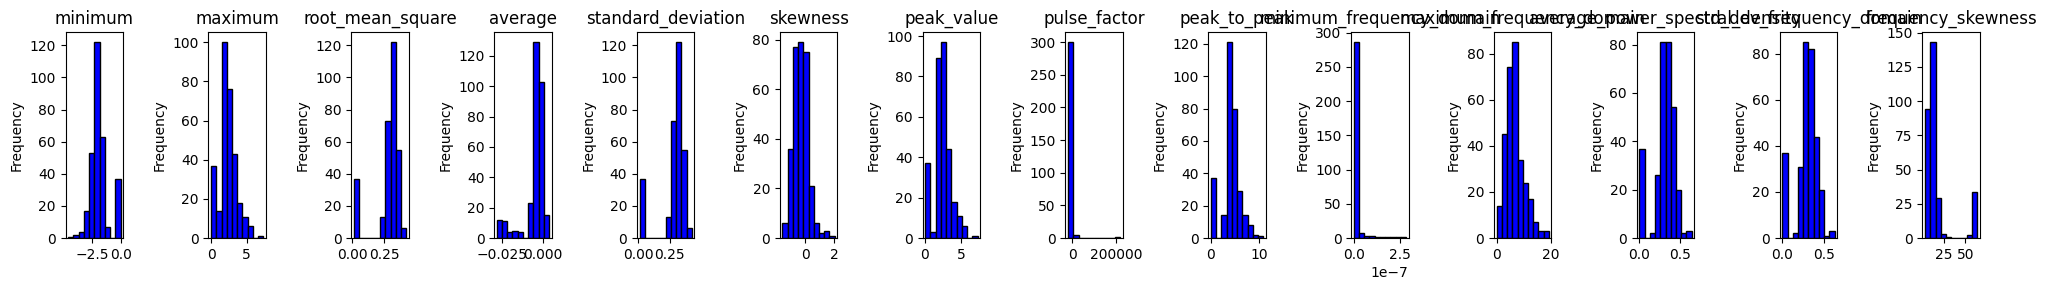

In [ ]:
import matplotlib.pyplot as plt

# Exclude 'time_stamp' from the columns to be plotted
columns_to_plot = [col for col in engineered_df.columns if col != 'time_stamp']

# Create subplots for each column
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(20, 3))

# Check if only one column (excluding time_stamp) to ensure axes indexing works
if len(columns_to_plot) == 1:
    axes = [axes]

# Iterate over each column and plot histogram
for i, column in enumerate(columns_to_plot):
    engineered_df[column].plot.hist(ax=axes[i], edgecolor='black', grid=False, color='blue')
    axes[i].set_title(column)

plt.tight_layout()
plt.show()


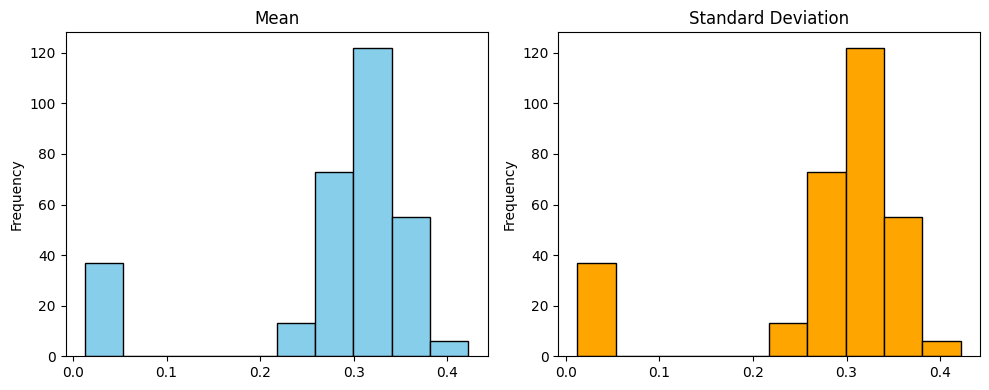

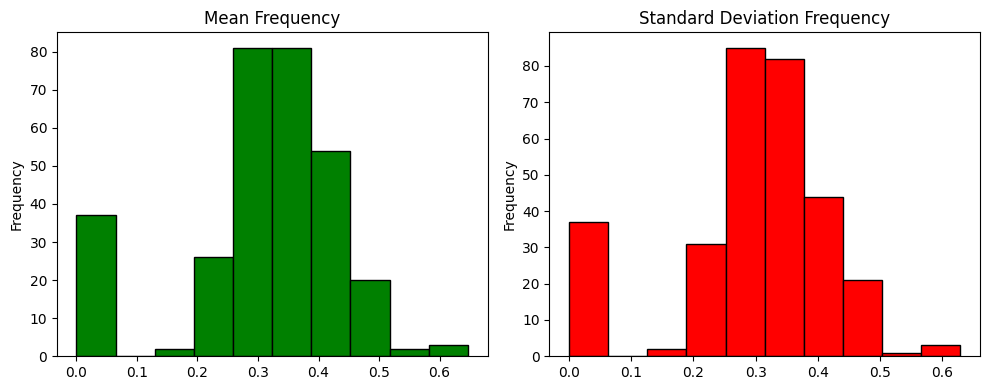

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms for 'mean' and 'std'
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
engineered_df['root_mean_square'].plot.hist(edgecolor='black', color='skyblue')
plt.title('Mean')

plt.subplot(1, 2, 2)
engineered_df['standard_deviation'].plot.hist(edgecolor='black', color='orange')
plt.title('Standard Deviation')

plt.tight_layout()
plt.show()

# Plot histograms for 'mean_freq' and 'std_freq'
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
engineered_df['average_power_spectral_density'].plot.hist(edgecolor='black', color='green')
plt.title('Mean Frequency')

plt.subplot(1, 2, 2)
engineered_df['std_dev_frequency_domain'].plot.hist(edgecolor='black', color='red')
plt.title('Standard Deviation Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Assigning labels based on conditions
engineered_df['Label'] = (engineered_df['average_power_spectral_density'] > 0.2) & (engineered_df['standard_deviation'] > 0.2)

# Convert boolean values to 0 or 1
engineered_df['Label'] = engineered_df['Label'].astype(int)


In [ ]:
engineered_df

time_stamp  minimum  maximum  root_mean_square   average  \
0    2021-06-01 04:09:32  -1.7914   2.8313          0.243599 -0.005710   
1    2021-06-01 05:49:49  -1.1648   1.7757          0.226936 -0.004755   
2    2021-06-01 07:30:16  -1.3162   1.8827          0.259281 -0.001733   
3    2021-06-01 09:10:35  -1.6617   1.8827          0.276530 -0.004551   
4    2021-06-01 10:50:43  -3.1707   4.0879          0.315362 -0.002341   
..                   ...      ...      ...               ...       ...   
301  2021-06-30 15:41:02  -2.0716   1.9889          0.271292 -0.002508   
302  2021-06-30 17:21:43  -2.3283   2.4788          0.358741 -0.000184   
303  2021-06-30 19:02:22  -2.0368   2.0489          0.305811 -0.002456   
304  2021-06-30 20:41:54  -1.8035   2.3422          0.282247 -0.001228   
305  2021-06-30 22:22:34  -1.9523   1.9741          0.287491 -0.001885   

     standard_deviation  skewness  peak_value  pulse_factor  peak_to_peak  \
0              0.243532  0.206301      2.8313   -495.884583        4.6227   
1              0.226886  0.501705      1.7757   -373.459195        2.9405   
2              0.259275  0.095969      1.8827  -1086.208775        3.1989   
3              0.276493 -0.113312      1.8827   -413.706965        3.5444   
4              0.315353  0.812204      4.0879  -1745.880174        7.2586   
..                  ...       ...         ...           ...           ...   
301            0.271280 -0.650313      2.0716   -825.881684        4.0605   
302            0.358741 -0.739167      2.4788 -13497.959053        4.8071   
303            0.305801 -0.803047      2.0489   -834.323617        4.0857   
304            0.282244 -0.146080      2.3422  -1907.551985        4.1457   
305            0.287485 -0.855081      1.9741  -1047.343868        3.9264   

     minimum_frequency_domain  maximum_frequency_domain  \
0                4.998036e-11                  3.477398   
1                1.426333e-10                  3.777210   
2                1.976564e-09                  3.563200   
3                7.336019e-10                  4.699245   
4                7.350306e-09                  4.890256   
..                        ...                       ...   
301              5.199851e-10                  4.756848   
302              1.094531e-10                 10.531011   
303              3.867973e-10                  4.211122   
304              6.801131e-10                  7.748326   
305              1.445812e-10                  6.896156   

     average_power_spectral_density  std_dev_frequency_domain  \
0                          0.186901                  0.177231   
1                          0.187987                  0.180795   
2                          0.229411                  0.219340   
3                          0.297269                  0.287265   
4                          0.307785                  0.291274   
..                              ...                       ...   
301                        0.239306                  0.227707   
302                        0.471924                  0.454037   
303                        0.290371                  0.274899   
304                        0.354255                  0.345181   
305                        0.312670                  0.301548   

     frequency_skewness  Label  
0              8.676911      0  
1             11.817668      0  
2              8.595131      1  
3              9.411329      1  
4              8.340158      1  
..                  ...    ...  
301            9.393950      1  
302           12.547322      1  
303            7.634990      1  
304           13.440380      1  
305           12.925199      1  

[306 rows x 16 columns]

In [ ]:
label_counts = engineered_df['Label'].value_counts()

# Calculate the percentage of each label
positive_percentage = (label_counts[1] / len(engineered_df)) * 100
negative_percentage = (label_counts[0] / len(engineered_df)) * 100


print("Percentage of positive labels (1): {:.2f}%".format(positive_percentage))
print("Percentage of negative labels (0): {:.2f}%".format(negative_percentage))

Percentage of positive labels (1): 86.93%
Percentage of negative labels (0): 13.07%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load your dataset into a pandas DataFrame
# Replace 'your_dataset.csv' with the actual file path or URL of your dataset


# Assuming your labels are in the last column, you can separate features and labels like this
X = engineered_df.iloc[:, 1:-1]  # Features
y = engineered_df.iloc[:, -1]   # Labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


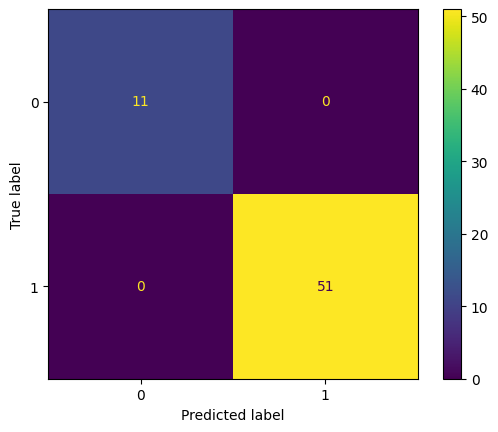

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from datetime import datetime
#create the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
#display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()


In [ ]:
def determine_onoff(classifier,x):
    new_df=engineer_features(x) #the output of this function is df
    y_newpred = classifier.predict(new_df) #global variable
    output=pd.DataFrame(y_newpred,x.iloc[:,0])
    return output

output=determine_onoff(rf_classifier,df_fanoutboard_x)

<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engineered_features_df = engineered_features_df.append({
<ipython-input-44-15df0346584c>:27: FutureWarning: The frame.append method is deprecated

In [ ]:
output

0
time_stamp            
2021-06-01 04:09:32  0
2021-06-01 05:49:49  0
2021-06-01 07:30:16  1
2021-06-01 09:10:35  1
2021-06-01 10:50:43  1
...                 ..
2021-06-30 15:41:02  1
2021-06-30 17:21:43  1
2021-06-30 19:02:22  1
2021-06-30 20:41:54  1
2021-06-30 22:22:34  1

[306 rows x 1 columns]

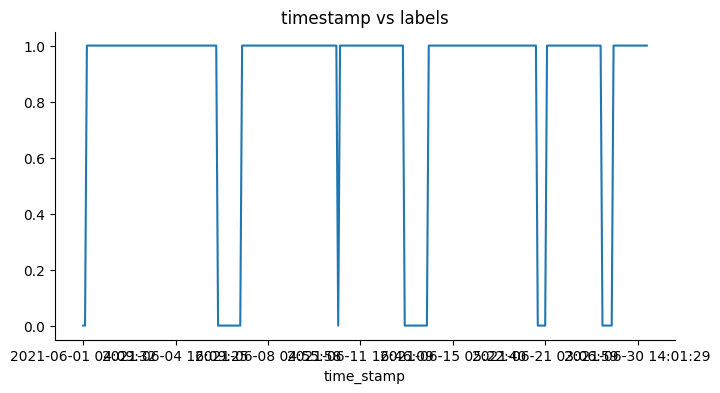

In [ ]:
# @title

from matplotlib import pyplot as plt
output[0].plot(kind='line', figsize=(8, 4), title= 'timestamp vs labels')
plt.gca().spines[['top', 'right']].set_visible(False)